# Final Project
This project will focus on some missing elements of my thesis, including:
- Graphs of the change in environmental variables with depth.
- PERMANOVA
    - Between strats and transects
    
    

## Graphs of the change in environmental variables with depth 
Graphs will be created of the changes in temperature, salinity, oxygen, pH, and particulate organic carbon (COP) with depth.
These variables were obtained from the COPERNICUS marine service and are associated with biological data. That is, there was a database of mollusks in the Eastern Tropical Pacific, and when the environmental data were downloaded, they were associated with all mollusk records in the databases. 
Everything will be in English except for the names of the variables in my database and the resulting graphs.

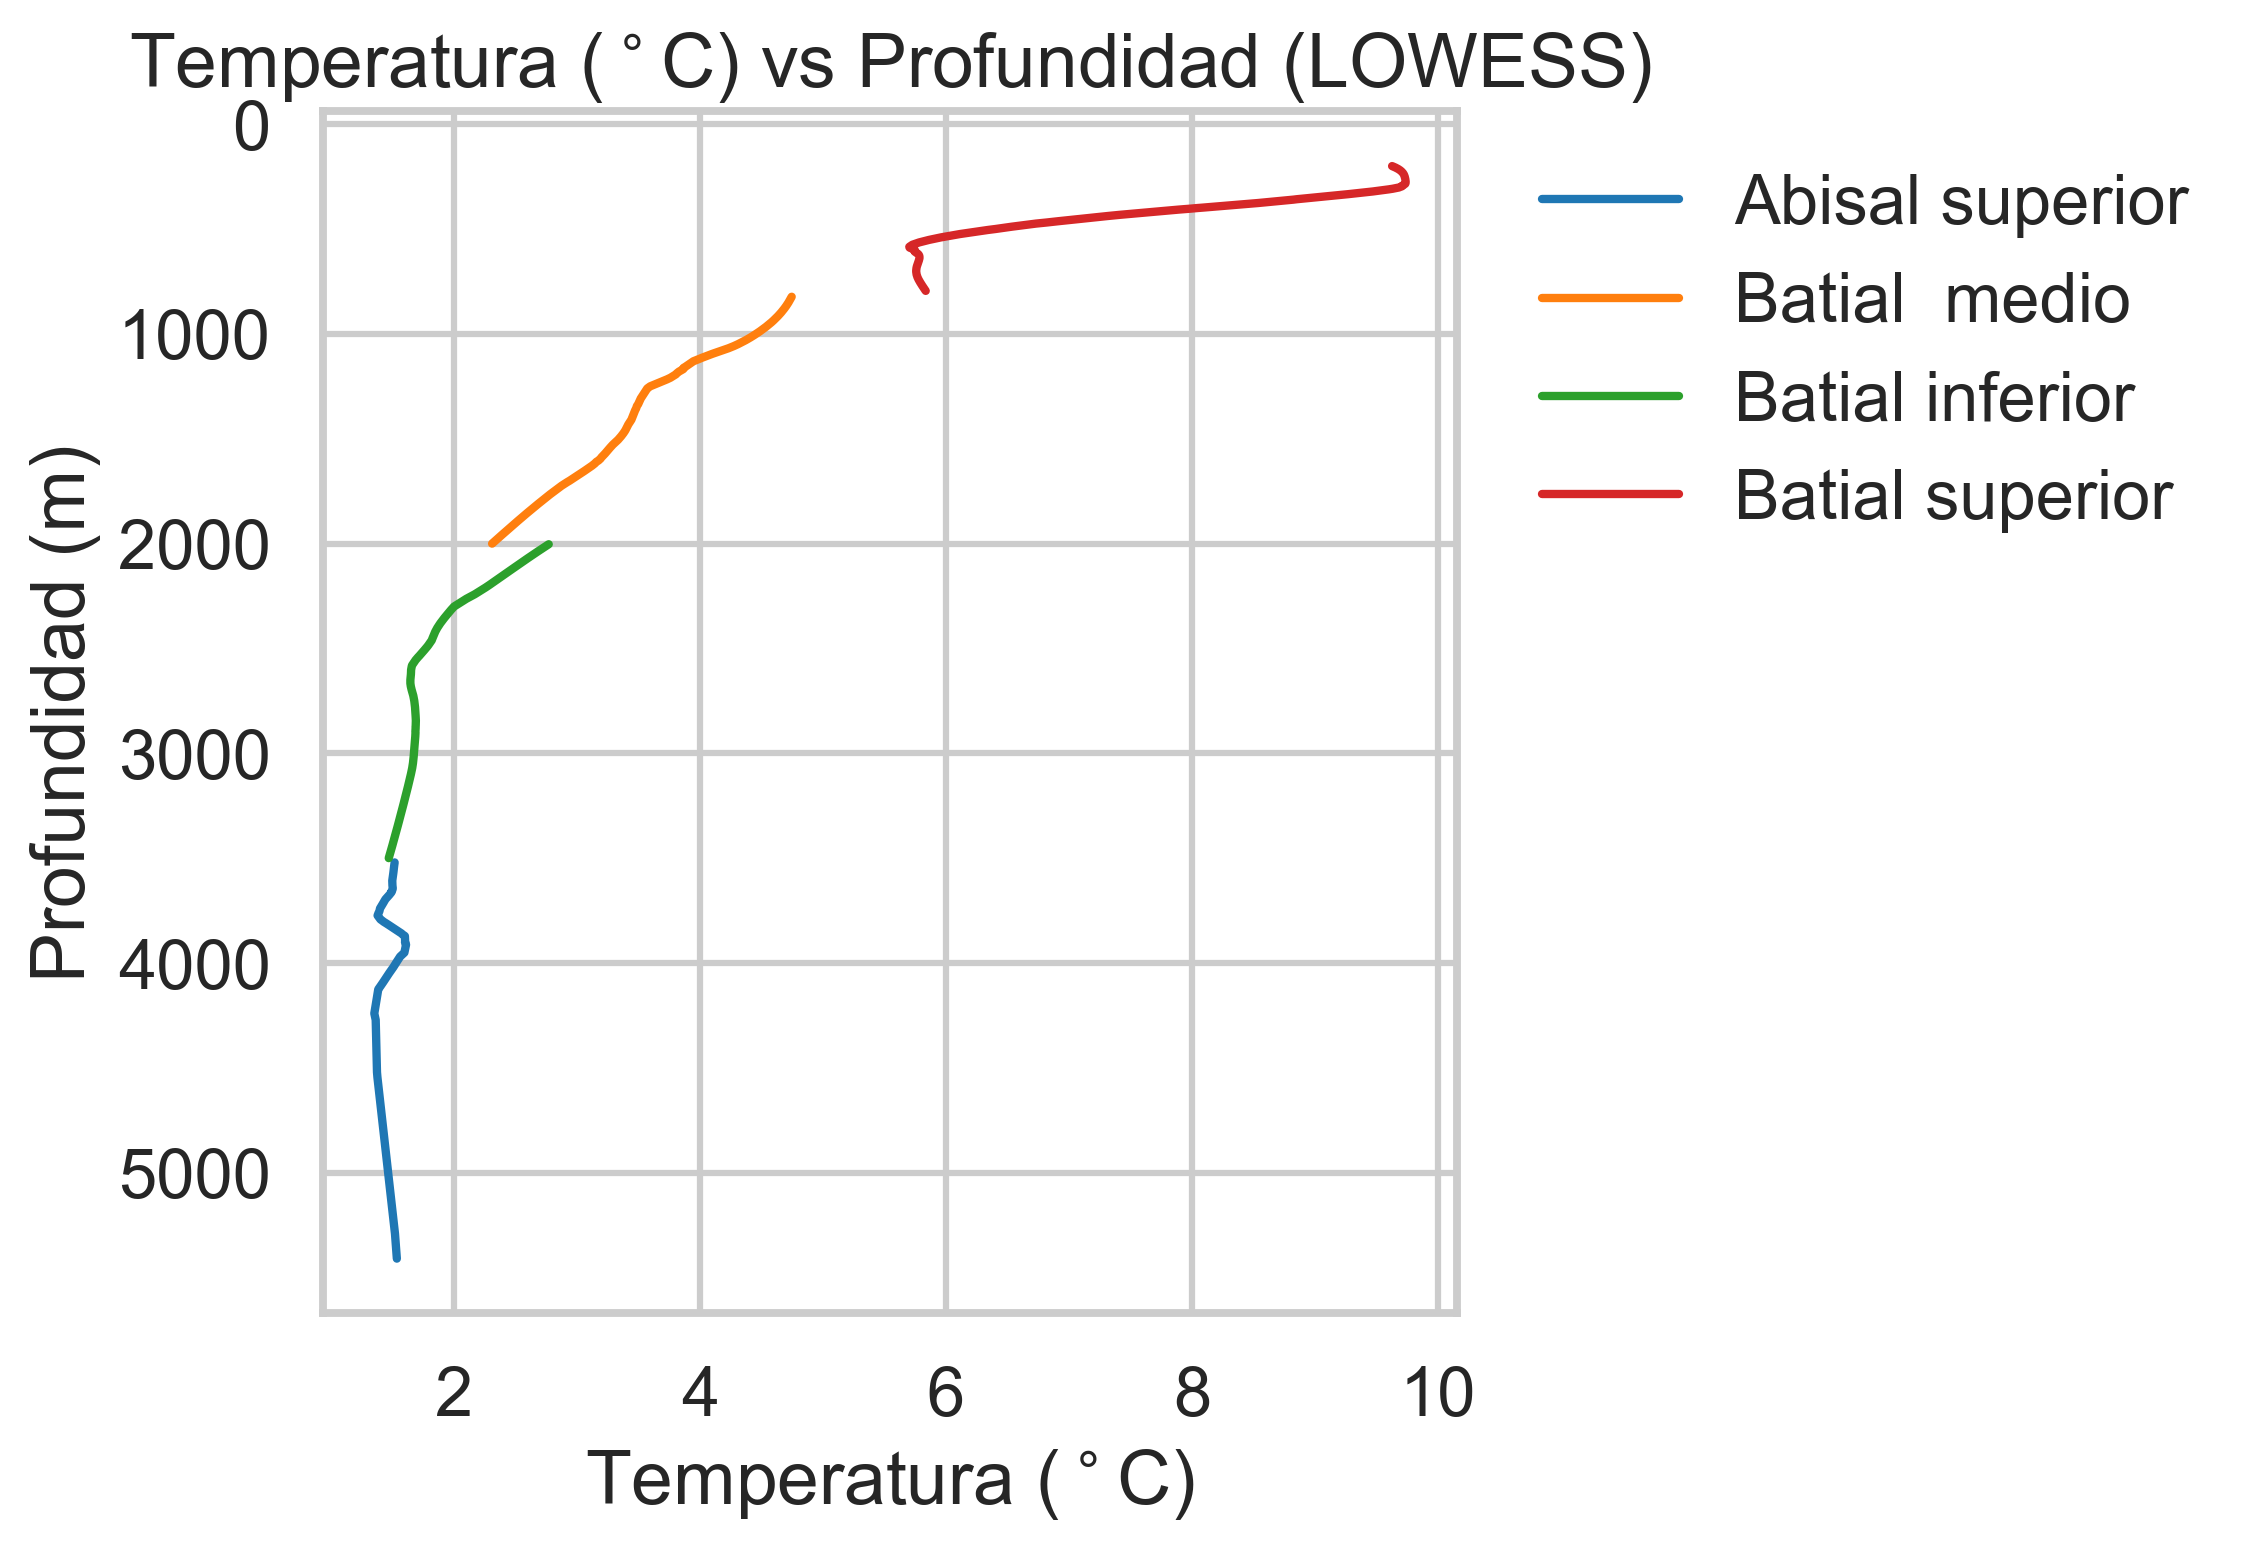

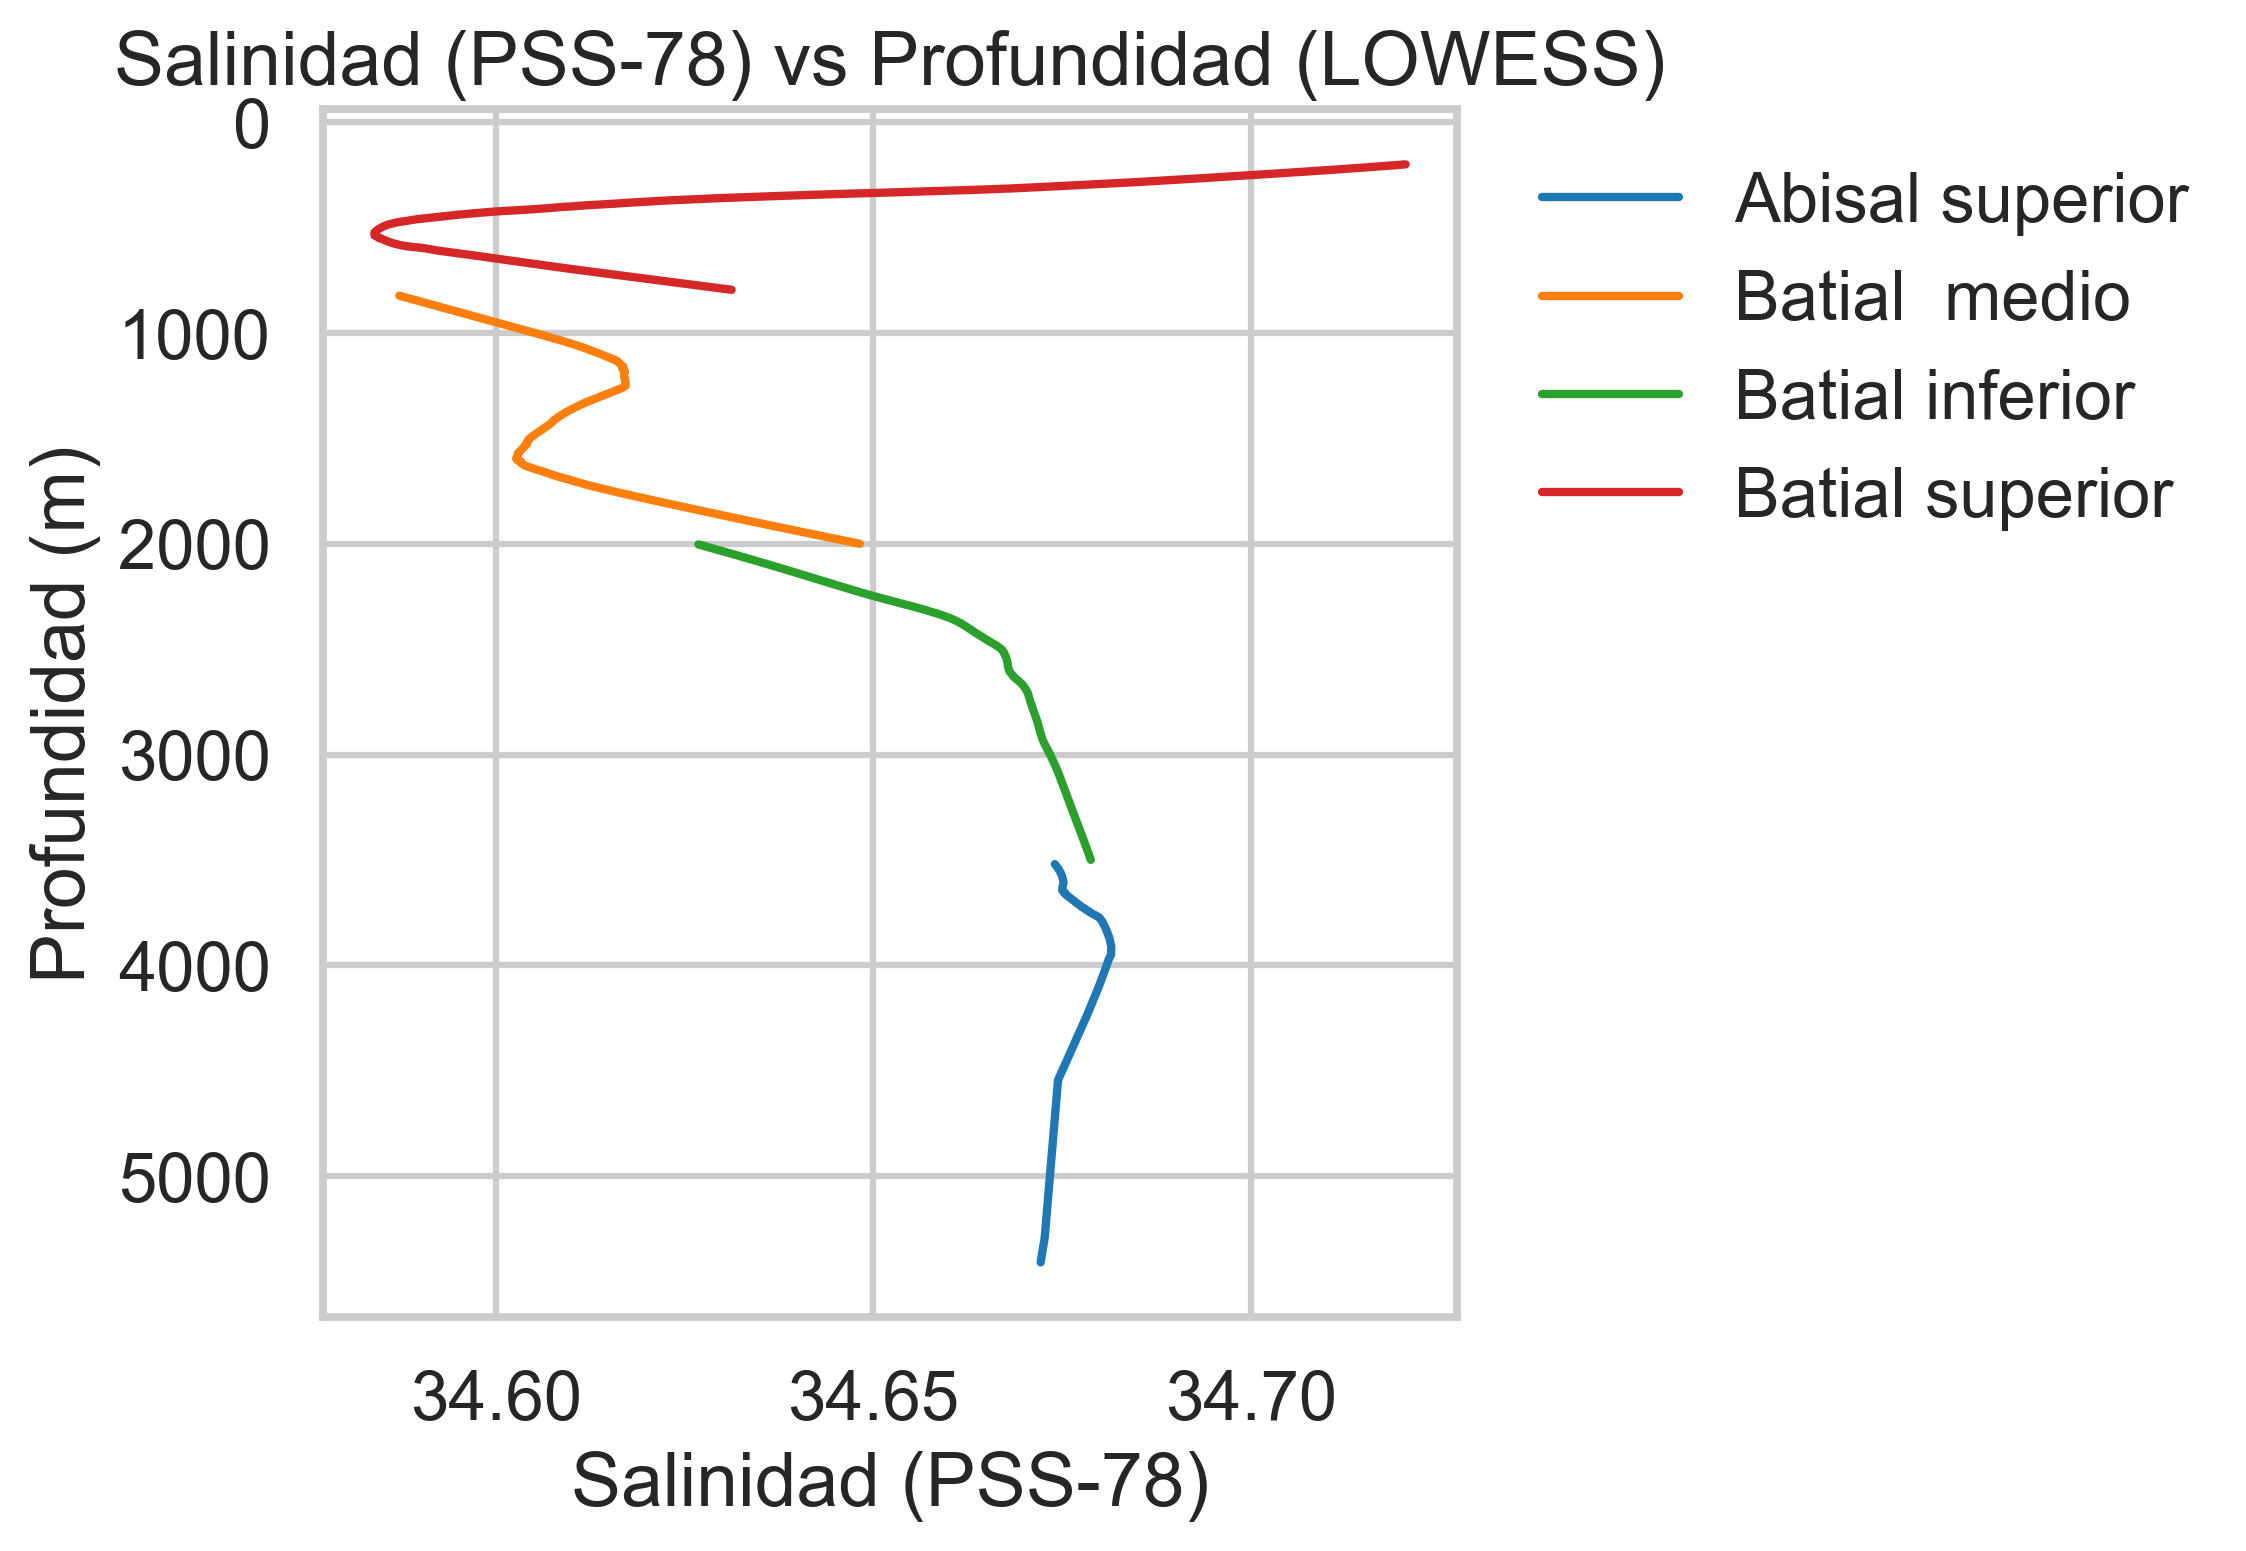

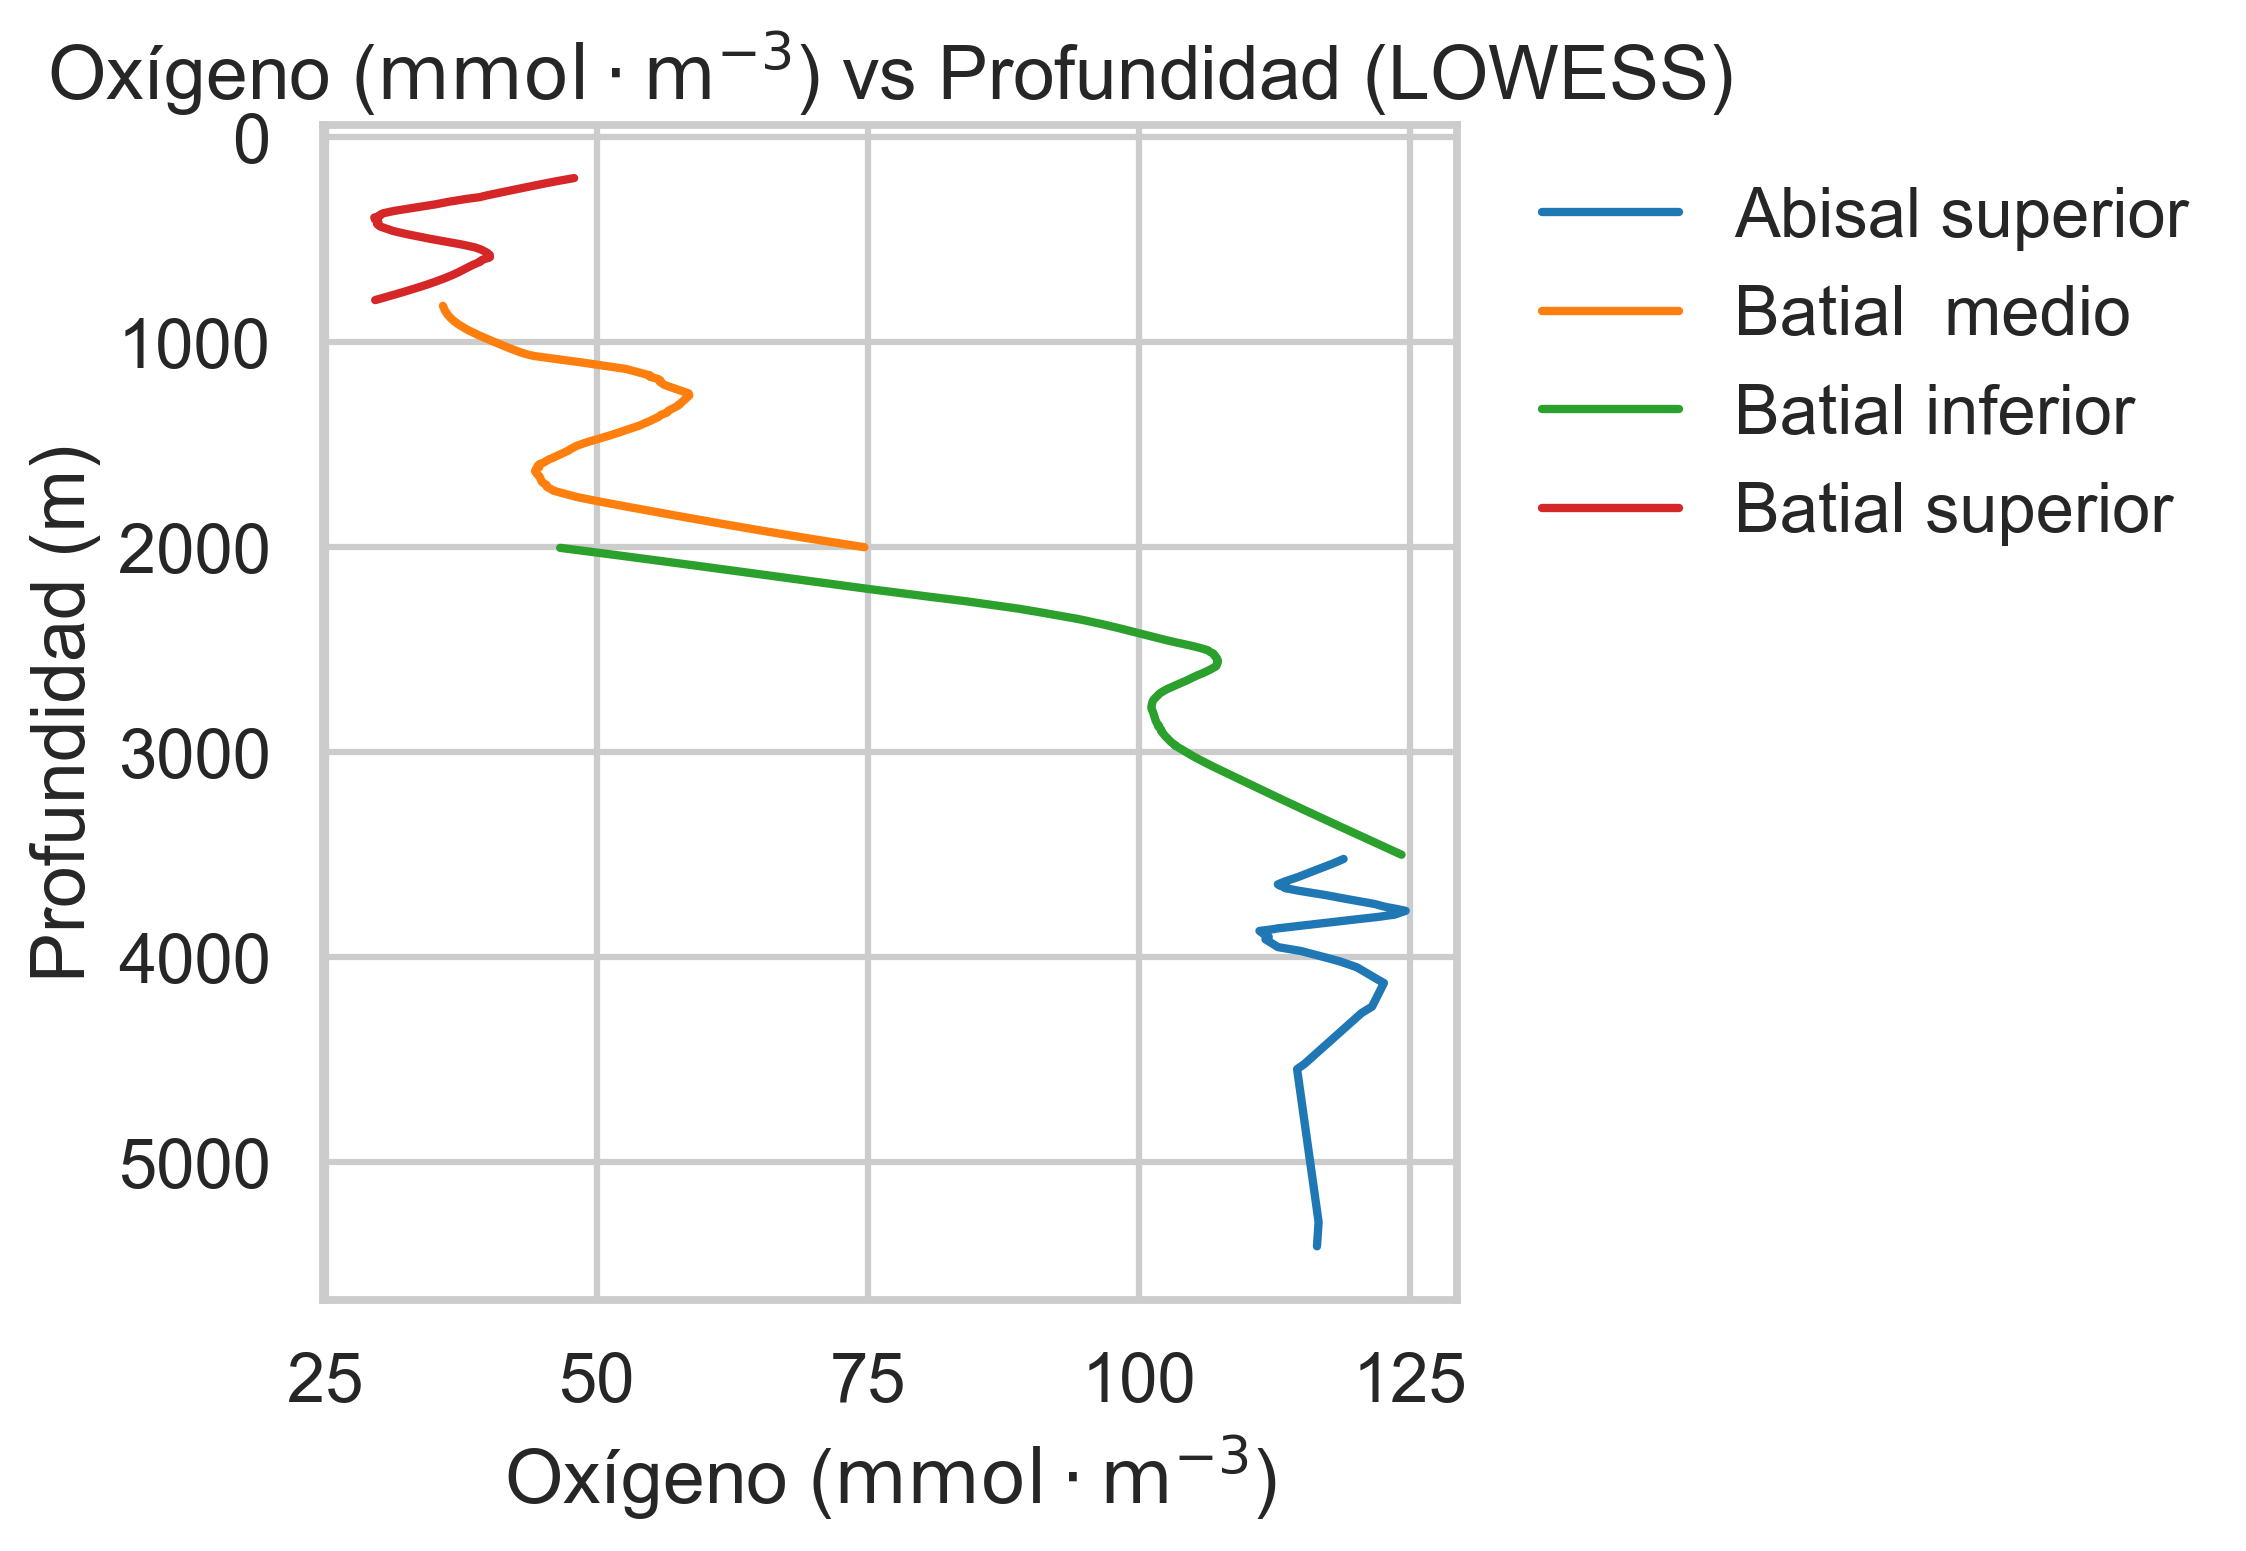

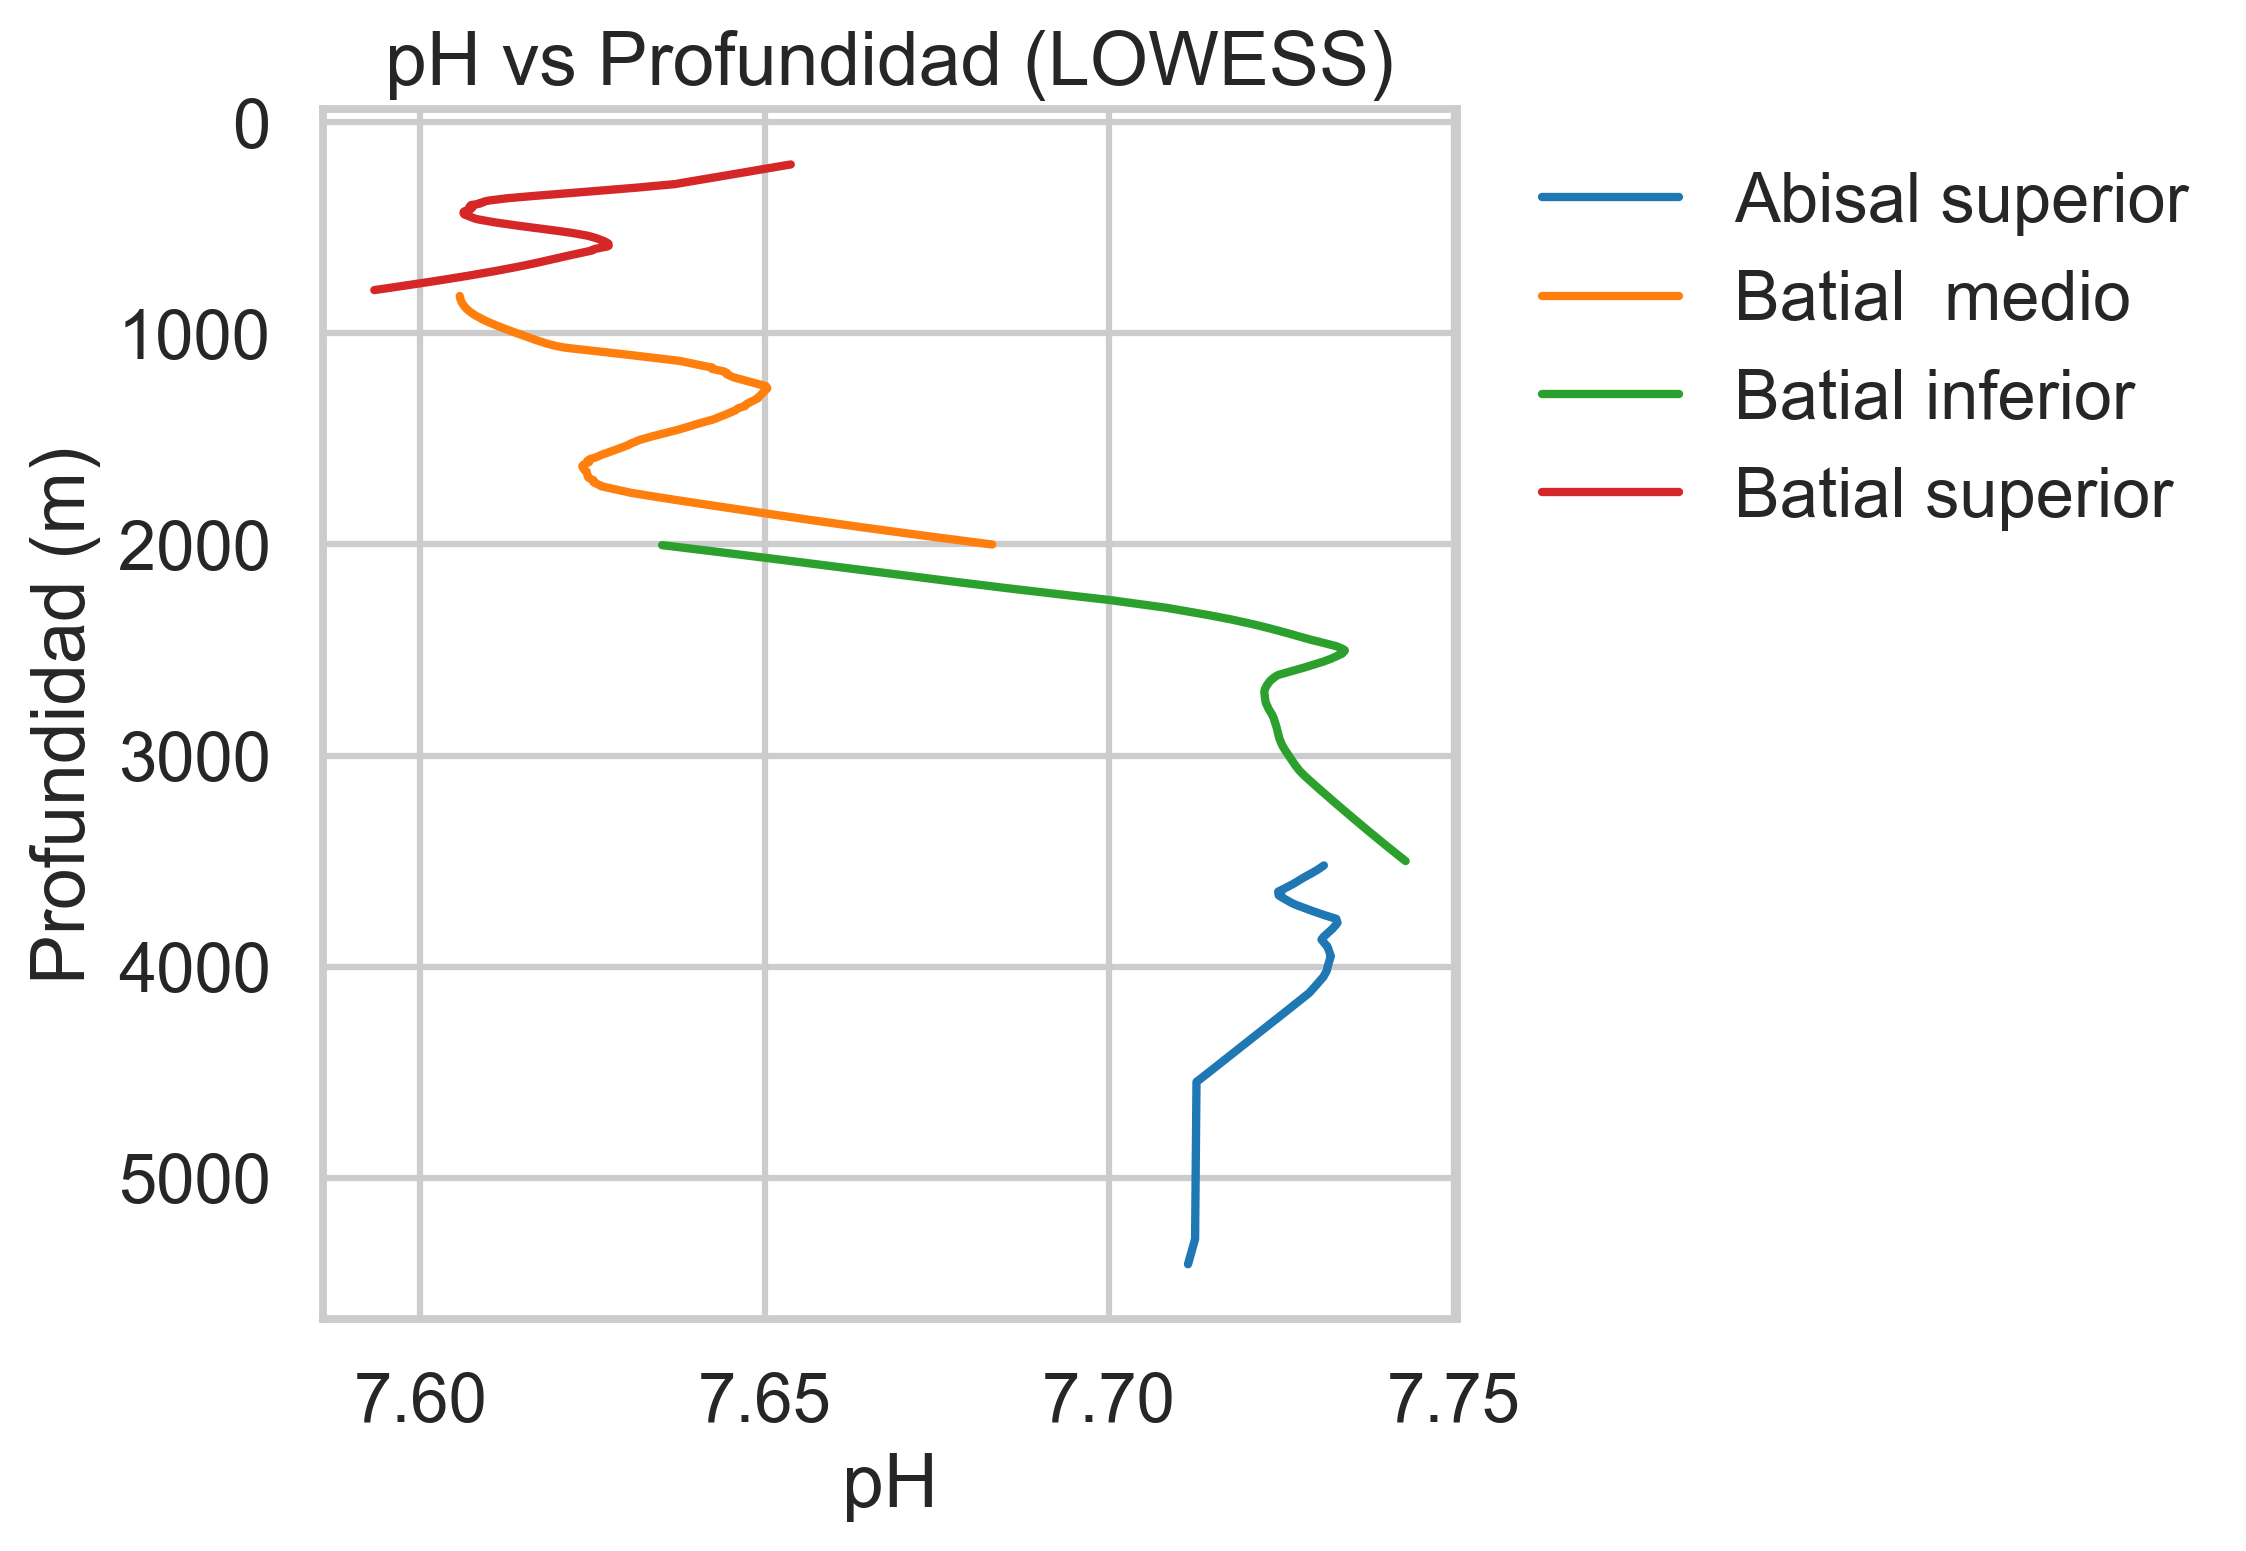

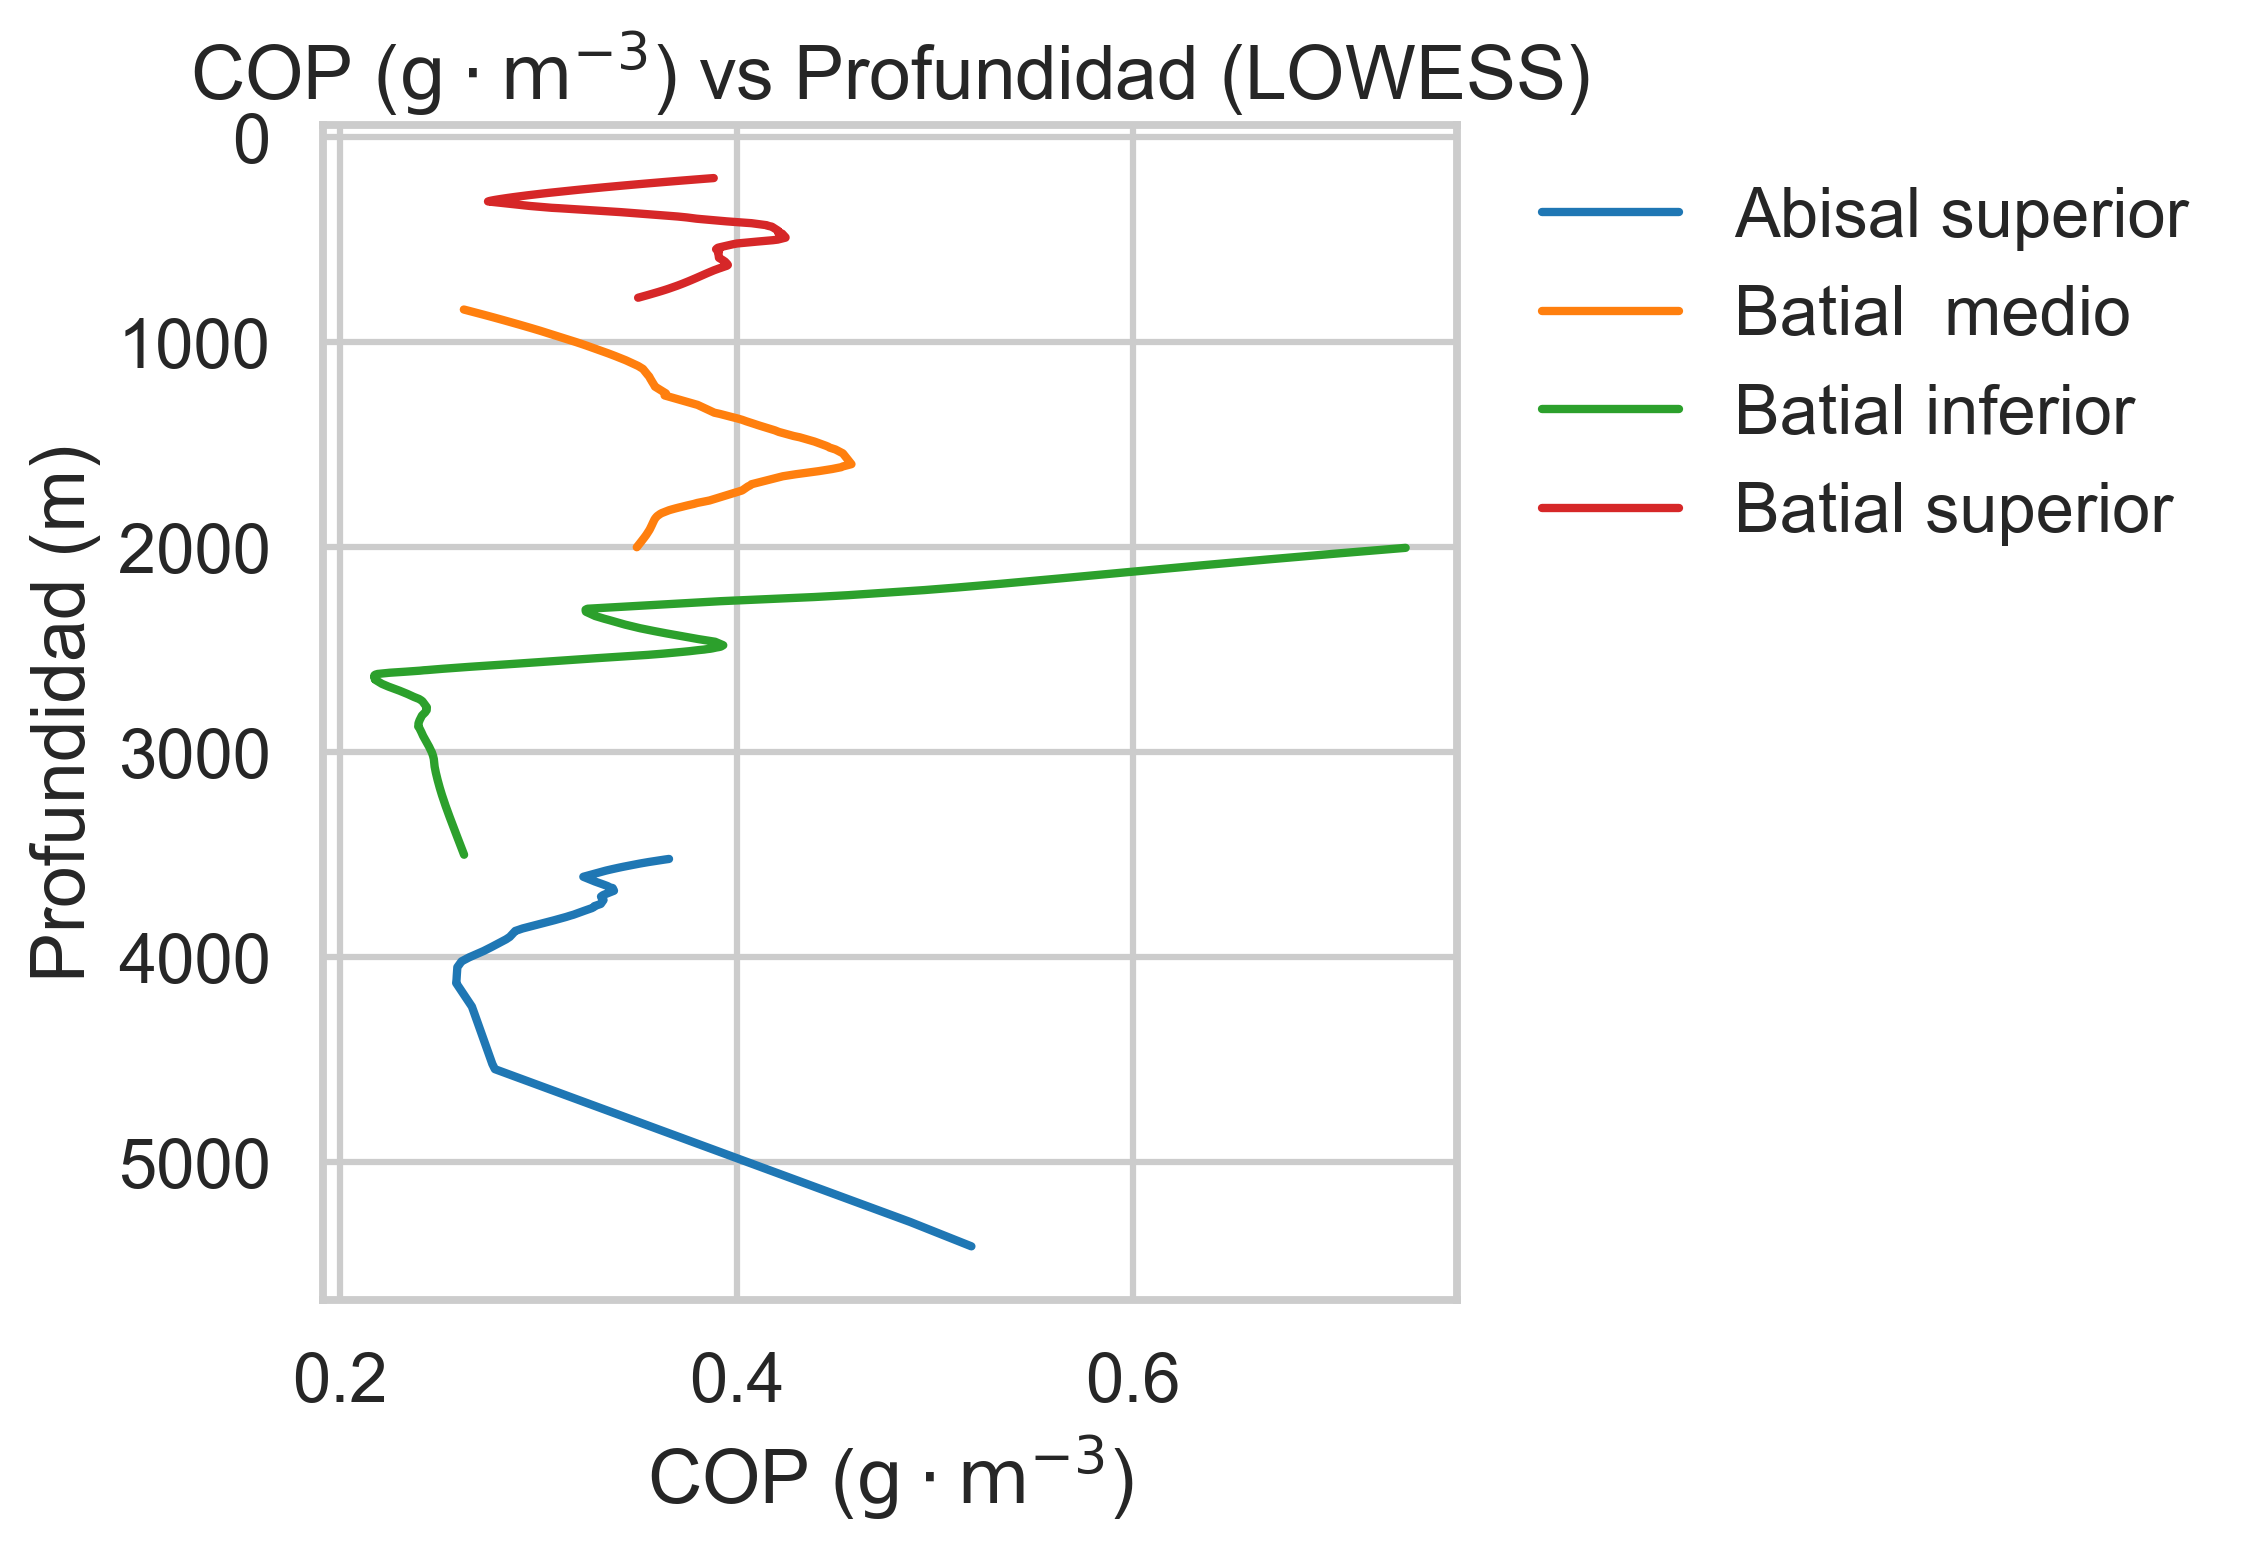

In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

sns.set_theme(style="whitegrid", context="talk")
def cm(w,h): return (w/2.54, h/2.54)

variables = ["temperatura", "salinidad", "oxigeno", "pH", "COP"]
palette = sns.color_palette("tab10")
frac = 0.45   # bigger = smoother (try 0.35–0.6)


xlabels = {
    "temperatura": r"Temperatura ($^\circ$C)",
    "salinidad":   r"Salinidad (PSS-78)",
    "oxigeno":     r"Oxígeno ($\mathrm{mmol}\cdot \mathrm{m}^{-3}$)",
    "pH":          r"pH",
    "COP":         r"COP ($\mathrm{g}\cdot \mathrm{m}^{-3}$)",
}

if "Estrato" in df.columns:
    for var in variables:
        d = df[["Estrato", "Profundidad", var]].dropna().copy()
        if d.empty:
            continue
        d["Estrato"] = d["Estrato"].astype(str).str.strip()

        # collapse data to median per stratum and depth
        d = (d.groupby(["Estrato","Profundidad"], observed=True)[var]
               .median().reset_index())

        plt.figure(figsize=cm(20,14), dpi=300)
        for i, (estrato, sub) in enumerate(d.groupby("Estrato")):
            sub = sub.sort_values("Profundidad")
            if len(sub) < 5:
                continue

            # LOWESS: y = var, x = profundidad
            smth = lowess(
                endog=sub[var].to_numpy(),
                exog=sub["Profundidad"].to_numpy(),
                frac=frac, it=1, return_sorted=True  # it=1 = robust
            )
            z = smth[:,0]  # depth
            y = smth[:,1]  # smoothed variable

            # plot line only
            plt.plot(y, z, lw=2, label=f"{estrato}", color=palette[i % len(palette)])

        plt.gca().invert_yaxis()
        xlab = xlabels.get(var, var)  # fall back to var if not in dict
        plt.title(f"{xlab} vs Profundidad (LOWESS)")
        plt.xlabel(xlab)
        plt.ylabel("Profundidad (m)")
        plt.legend(frameon=False, bbox_to_anchor=(1.02,1), loc="upper left")
        plt.tight_layout()
        plt.savefig(f"{var}_perfil_LOWESS.png", dpi=300, bbox_inches="tight")
        plt.show()



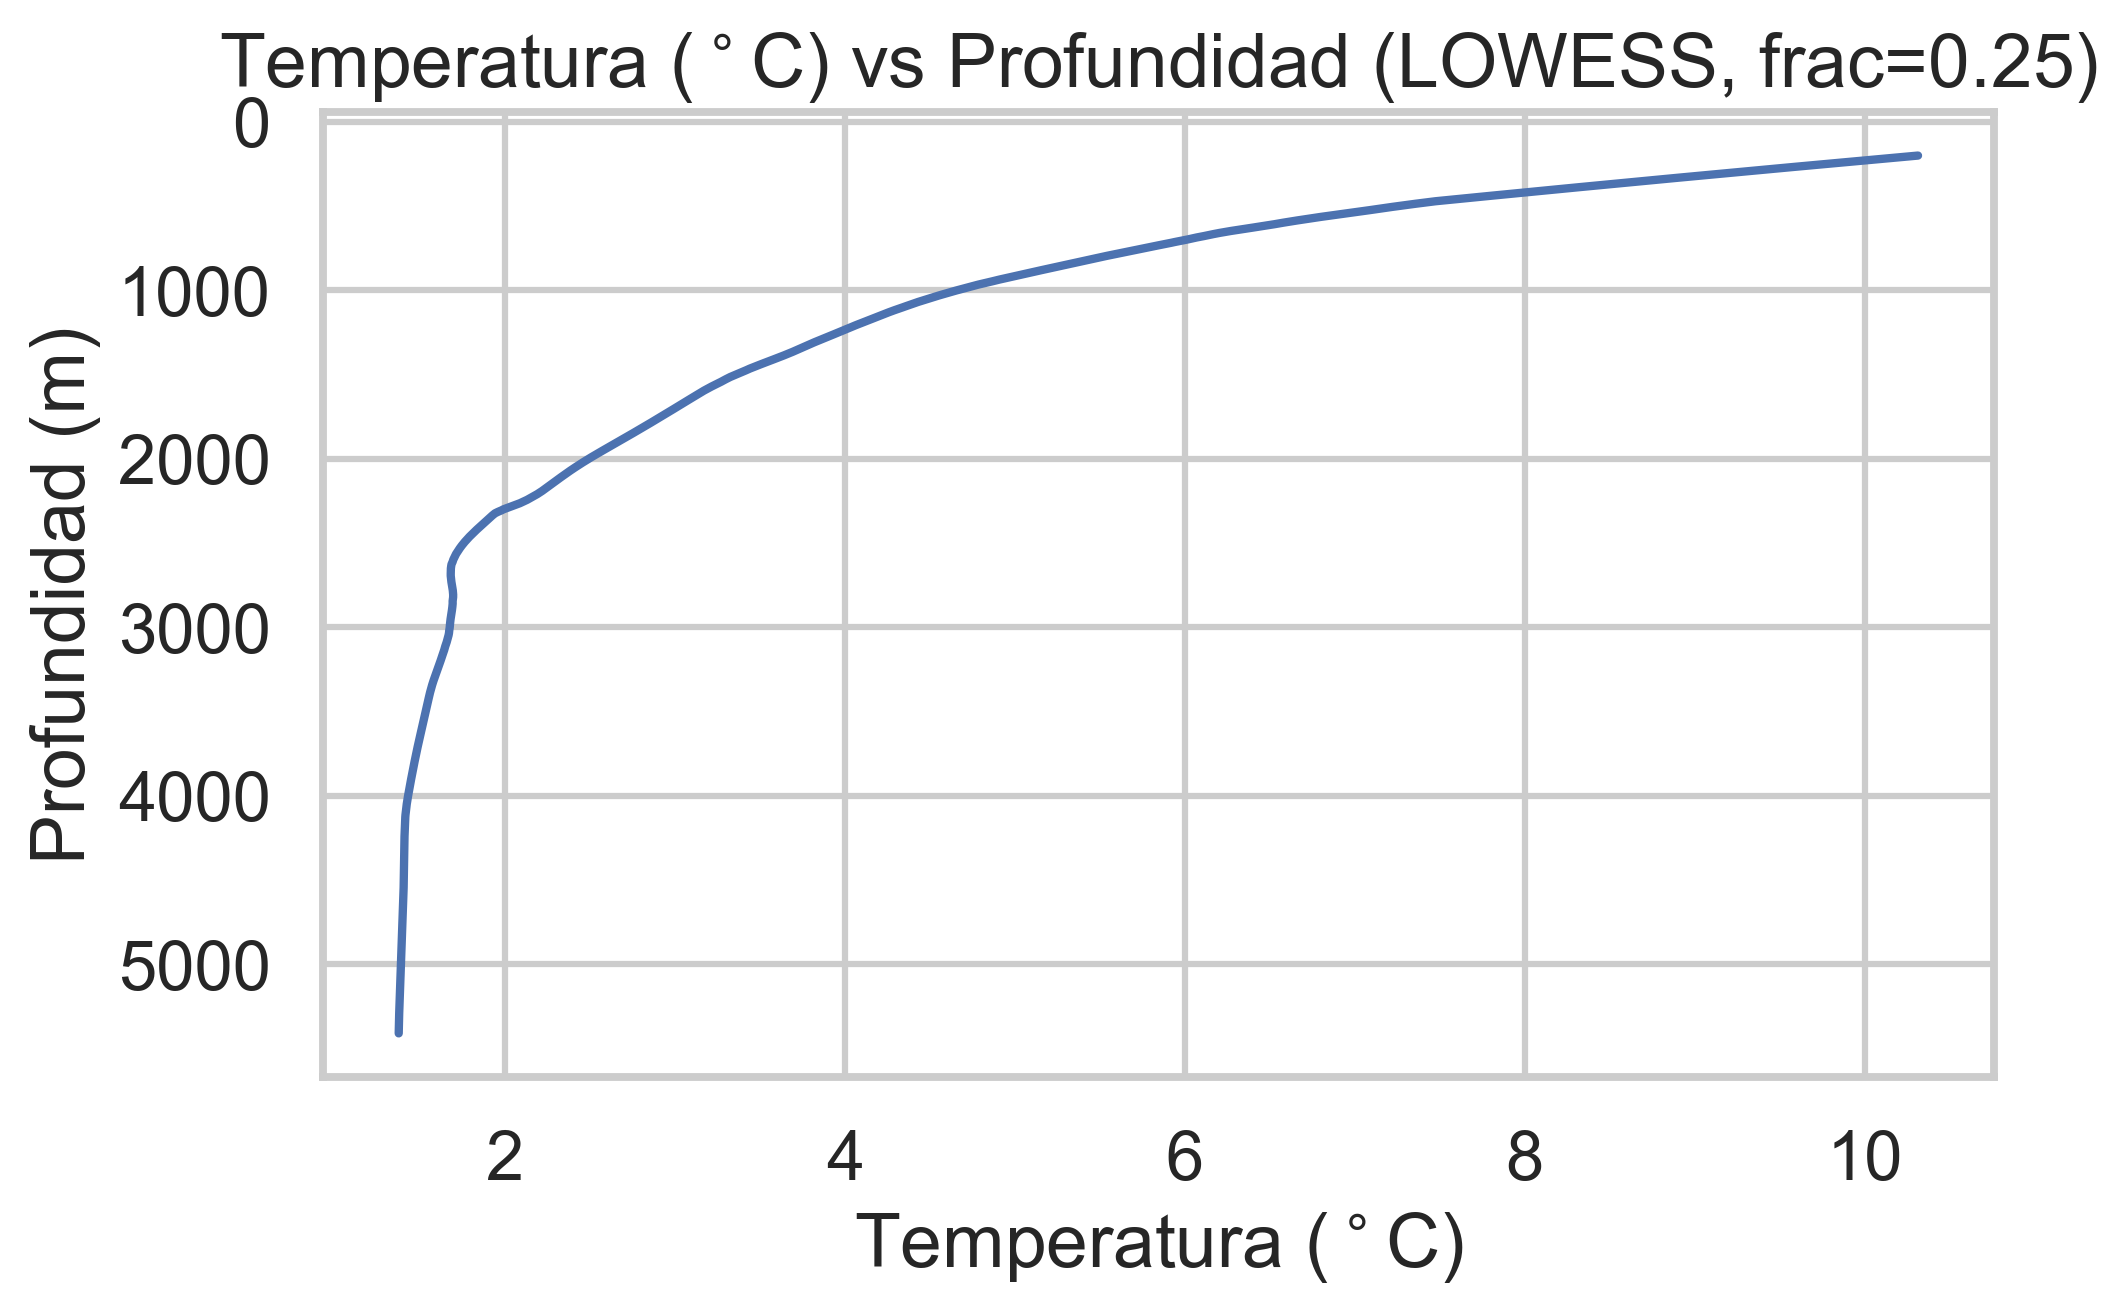

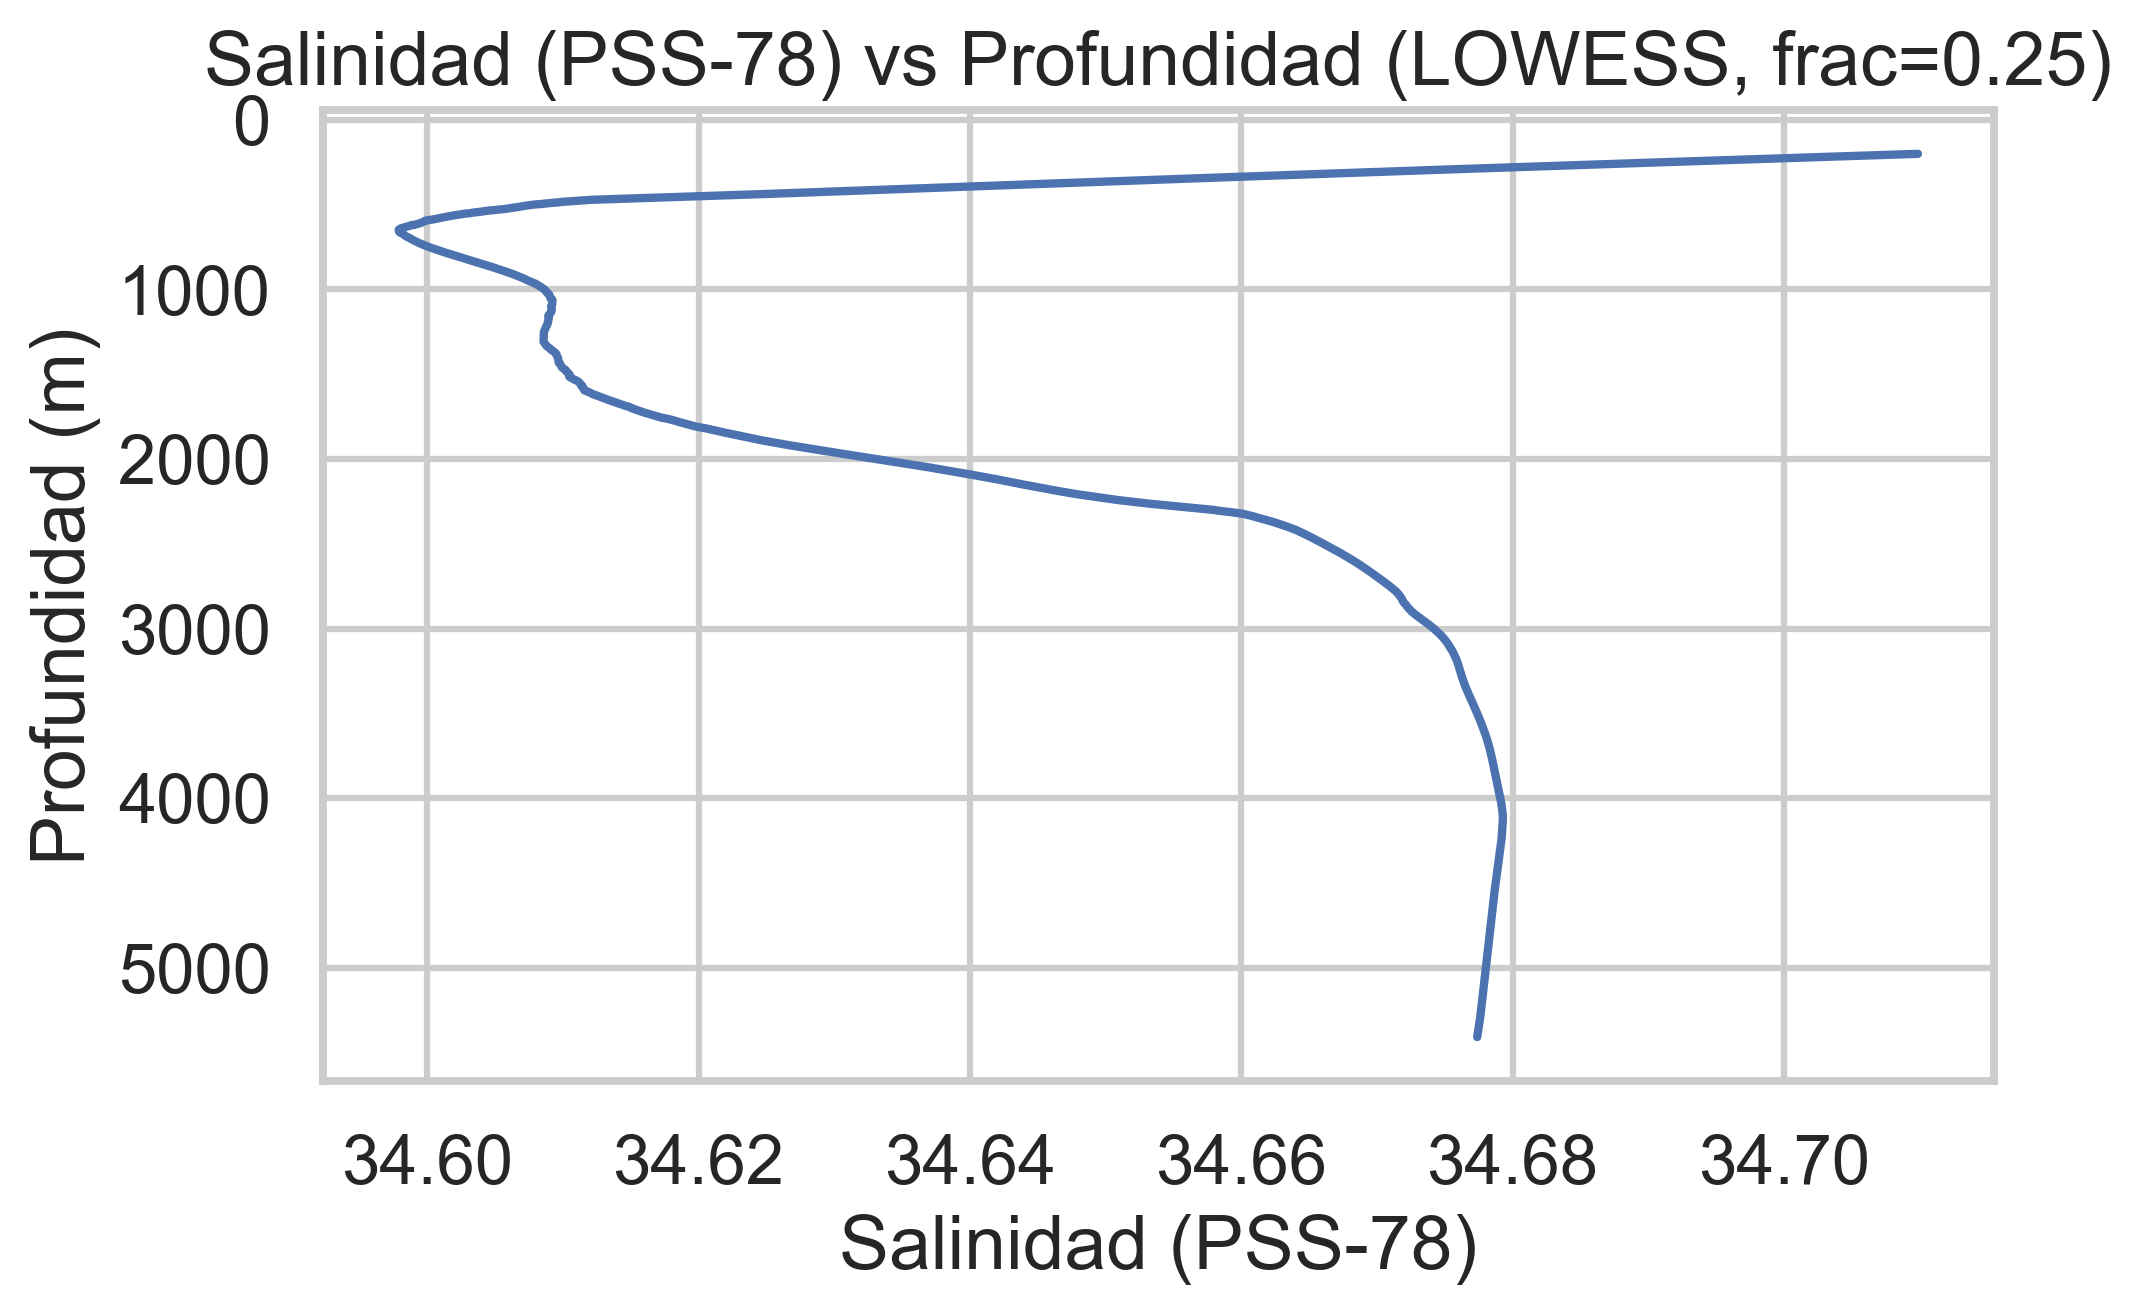

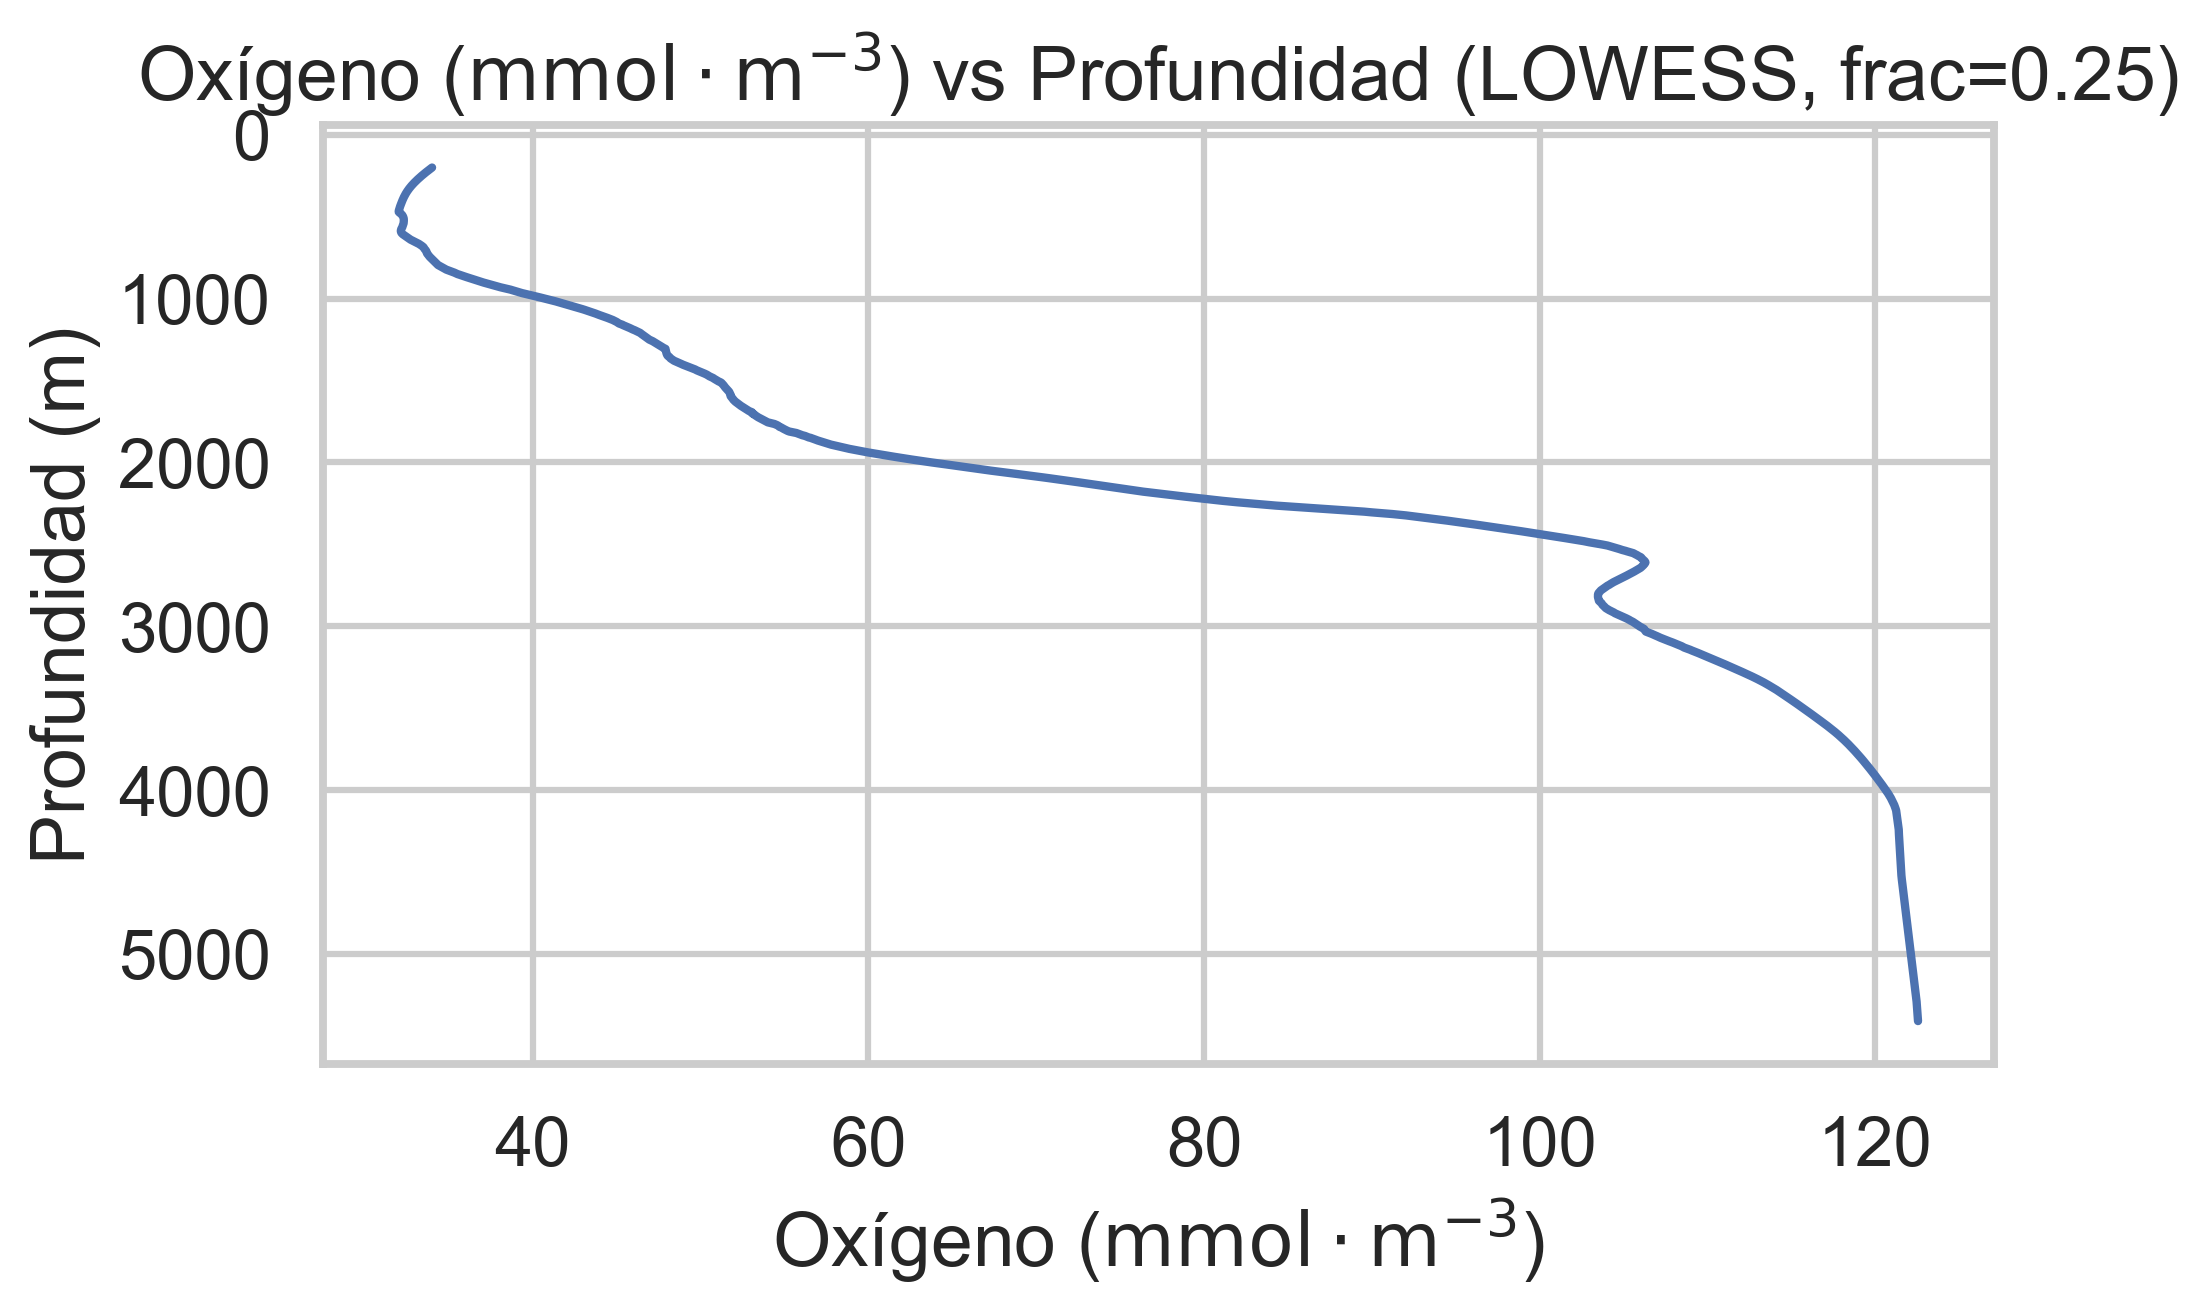

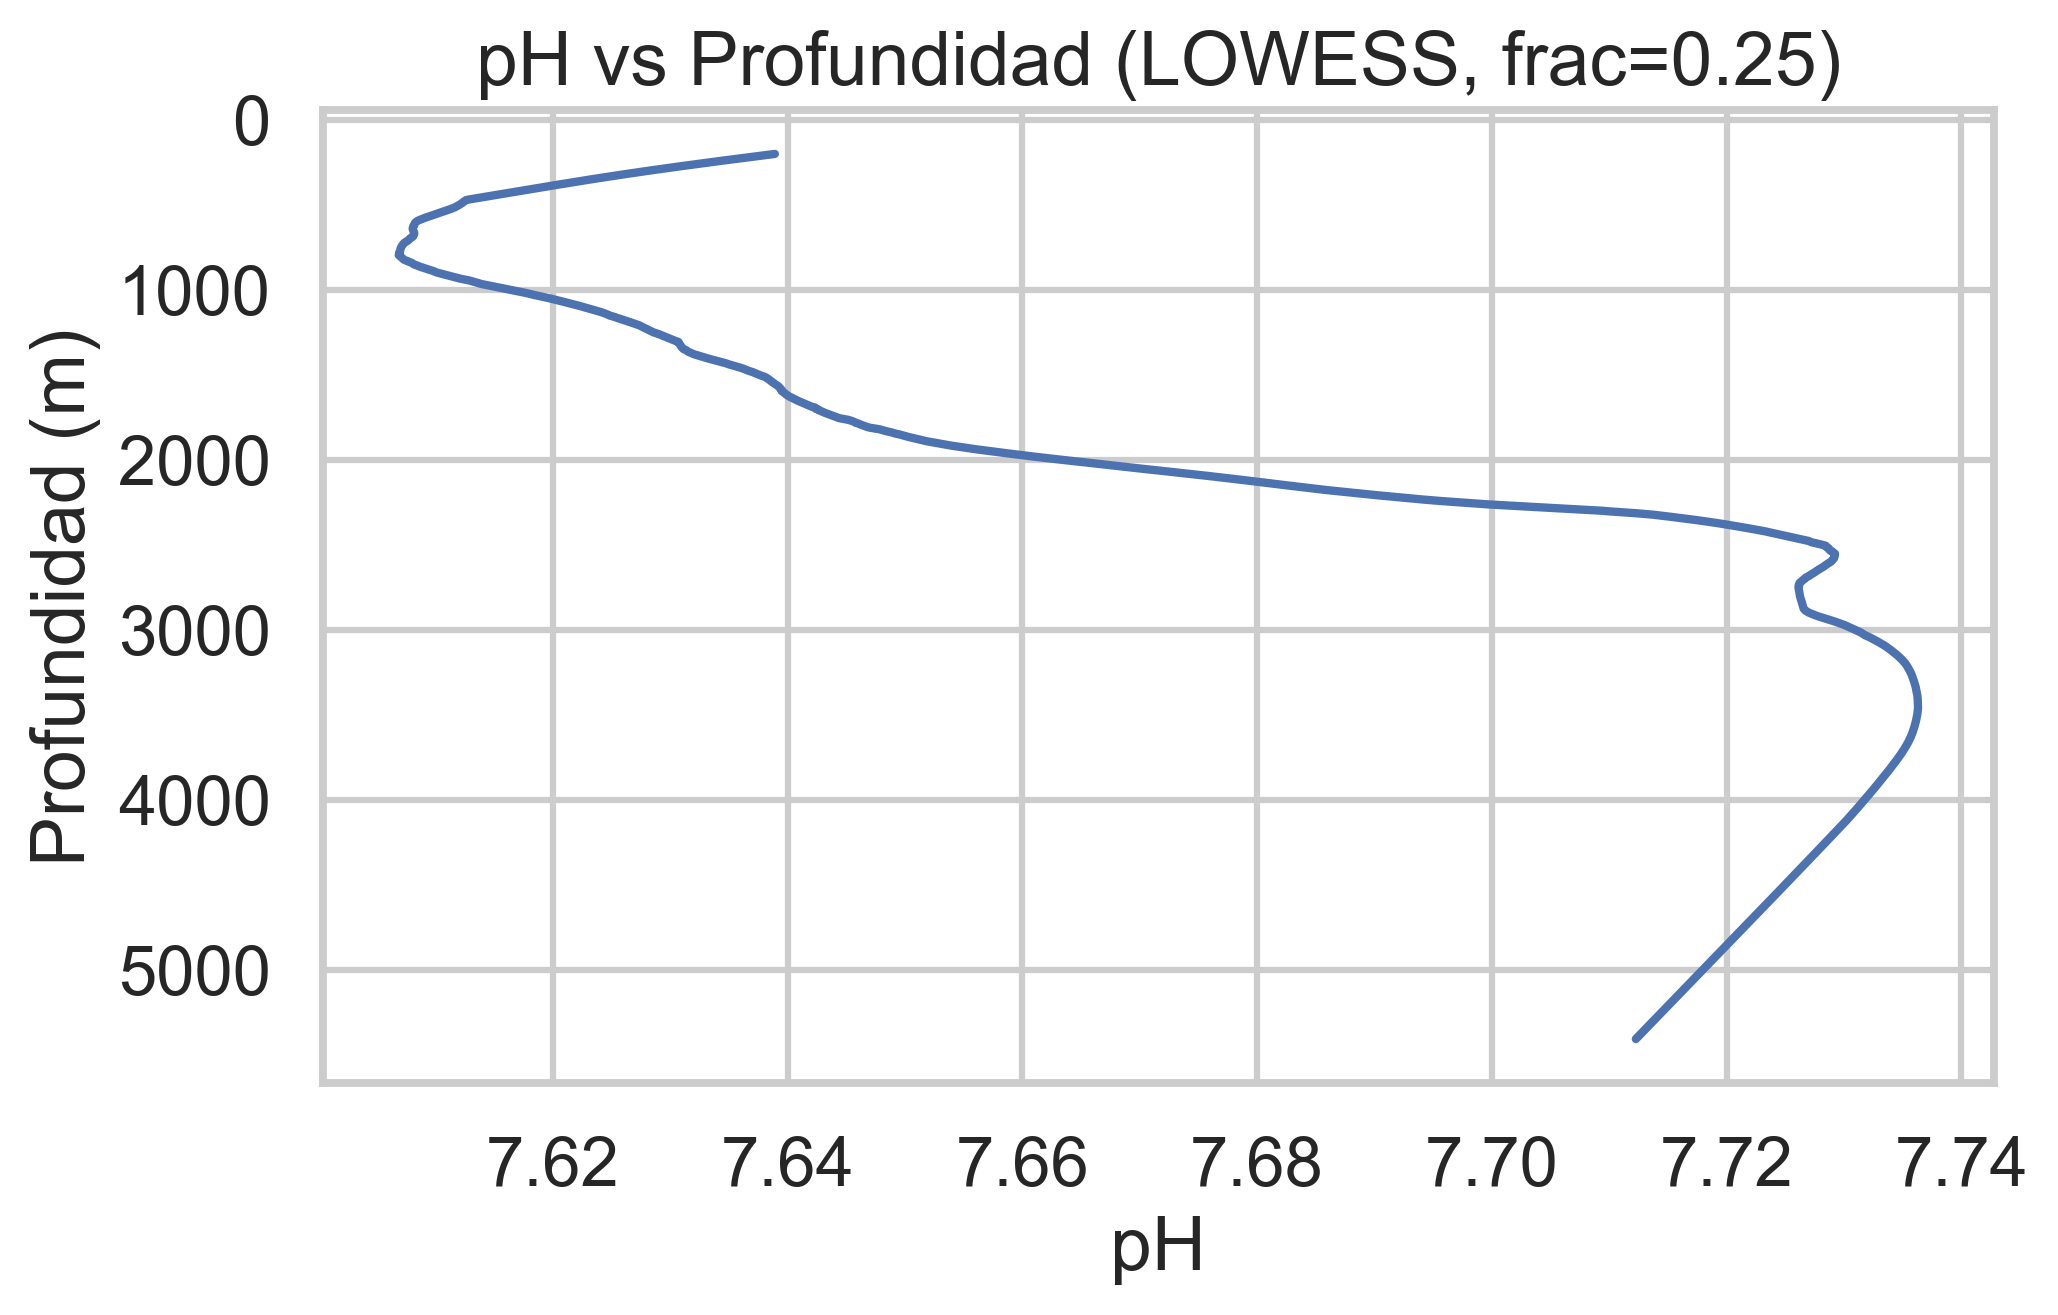

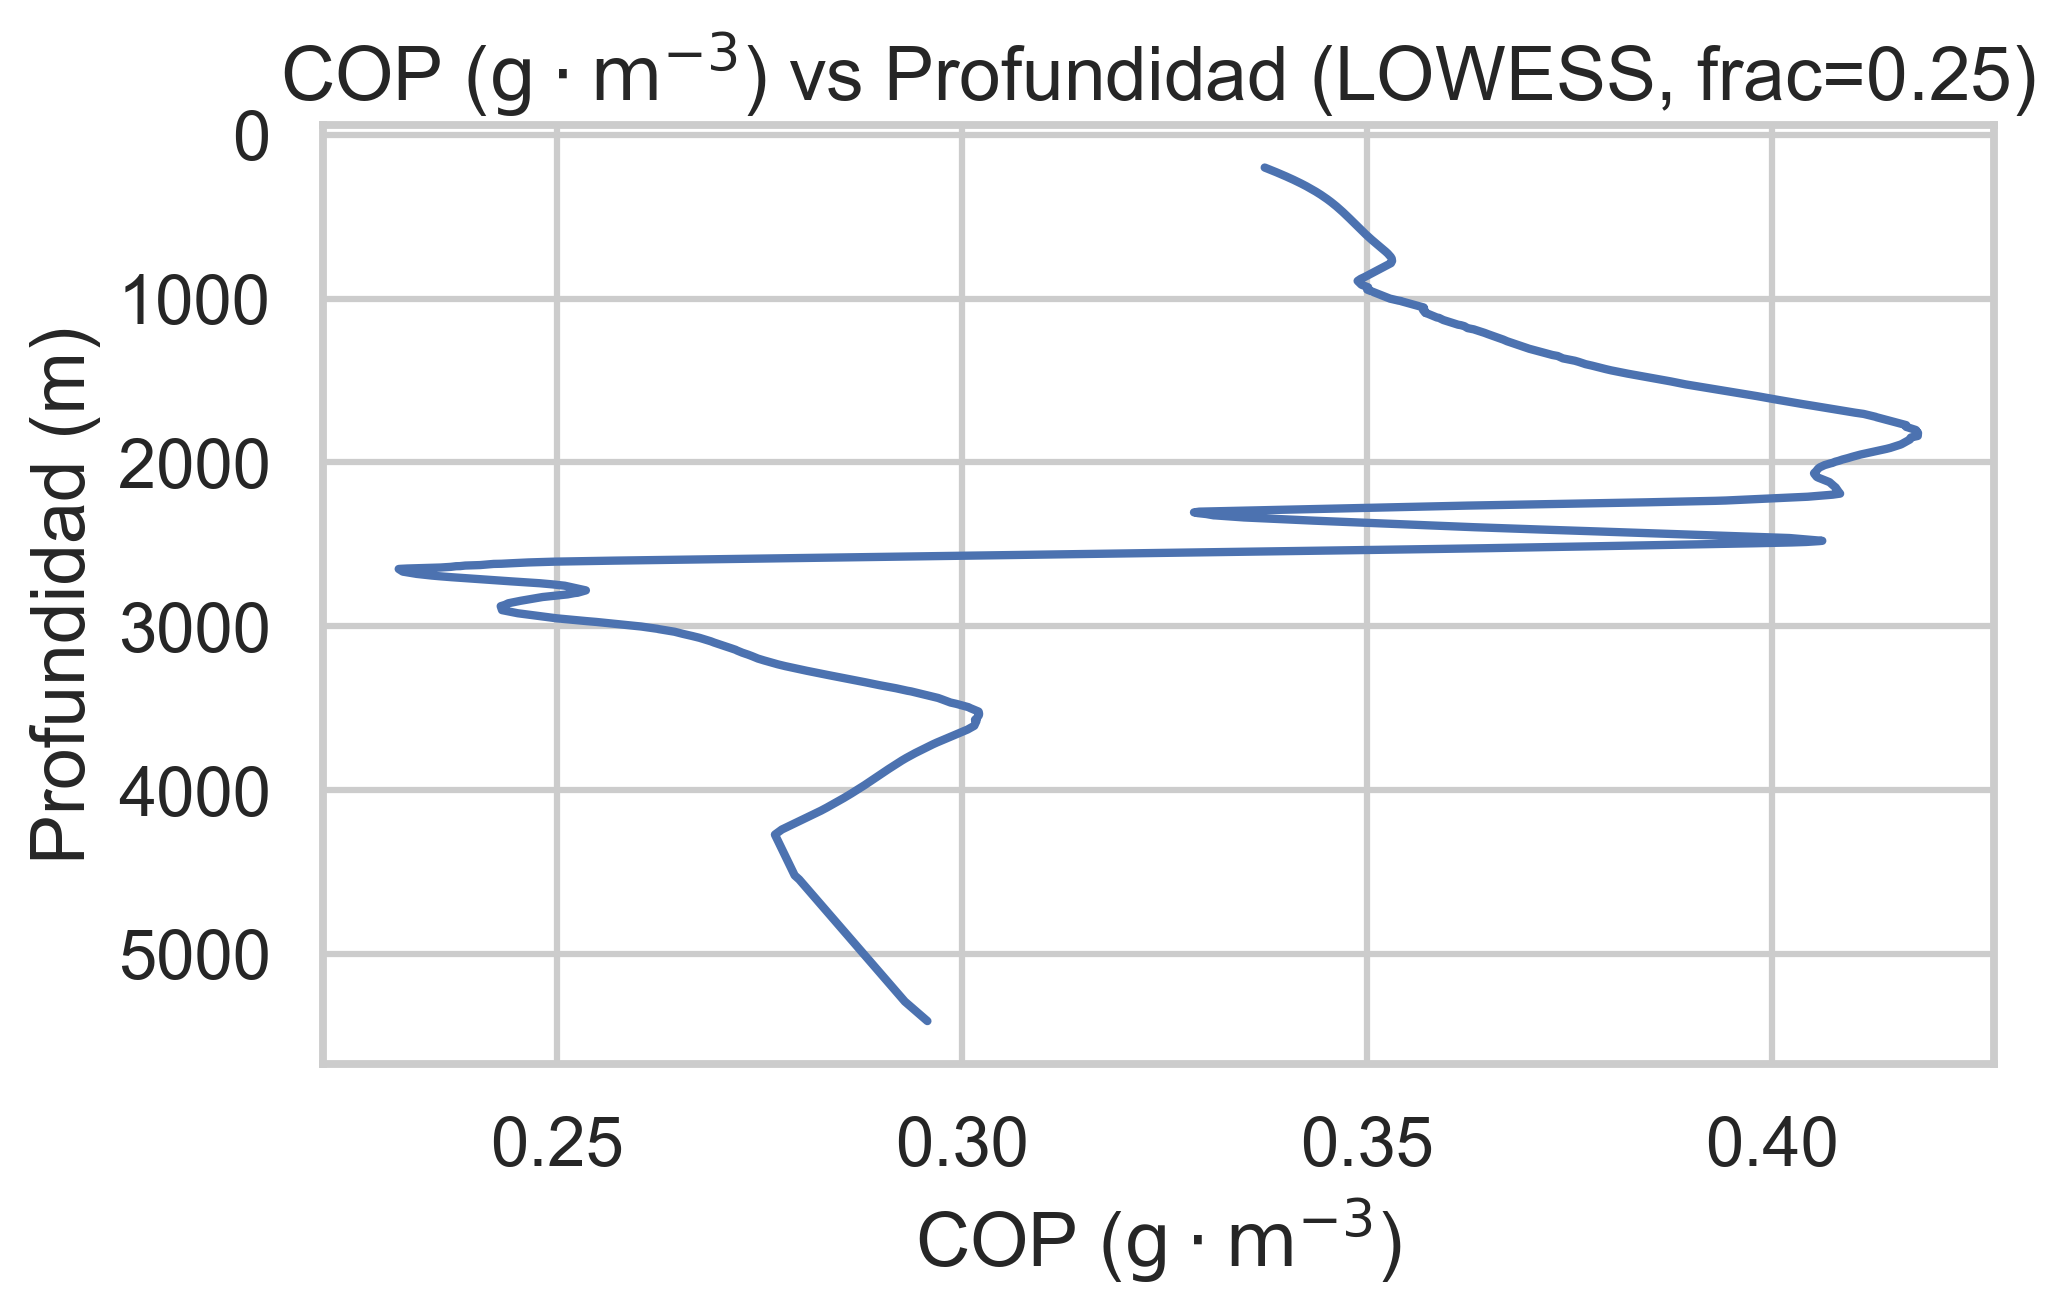

Done. Increase LOWESS_FRAC (e.g., 0.55–0.65) or set ROUND_DEPTH_STEP (e.g., 50–100) for smoother lines.


In [30]:
# ============================================
# Smooth profiles (LOWESS) per variable vs depth (no strata)
# - One line per variable (no scatter points)
# - Median collapse at identical (or rounded) depths
# - Robust LOWESS smoothing
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess

# ----------- Plot style / helpers -----------
sns.set_theme(style="whitegrid", context="talk")
def cm(w, h):  # size in centimeters
    return (w/2.54, h/2.54)

# ----------- Configuration -----------
CSV_PATH     = "especies_sin_NA.csv"  # path to your CSV file
DEPTH_COL    = "Profundidad"          # depth column name in your file
VARIABLES    = ["temperatura", "salinidad", "oxigeno", "pH", "COP"]

# LOWESS controls: larger 'frac' = smoother; 'it=1' = robust to outliers
LOWESS_FRAC  = 0.25
LOWESS_IT    = 1

# Optional: round depths before collapsing (set to an integer like 50 for 50 m; or None to skip)
ROUND_DEPTH_STEP = None  # e.g., 50 or 100 for extra smoothing

# --- X-axis labels with units (Unicode) ---
XLABELS = {
    "temperatura": r"Temperatura ($^\circ$C)",
    "salinidad":   r"Salinidad (PSS-78)",
    "oxigeno":     r"Oxígeno ($\mathrm{mmol}\cdot \mathrm{m}^{-3}$)",
    "pH":          r"pH",
    "COP":         r"COP ($\mathrm{g}\cdot \mathrm{m}^{-3}$)",
}

# ----------- Load data -----------
df = pd.read_csv(CSV_PATH)

# Fix a common typo in depth column if present
if DEPTH_COL not in df.columns and "Profundidad" in df.columns:
    df = df.rename(columns={"Profundidad": DEPTH_COL})

# ----------- Main loop -----------
for var in VARIABLES:
    if var not in df.columns:
        print(f"[Note] Variable '{var}' not found. Skipping.")
        continue

    # Keep only depth and the target variable; ensure numeric and drop missing
    d = df[[DEPTH_COL, var]].copy()
    d[DEPTH_COL] = pd.to_numeric(d[DEPTH_COL], errors="coerce")
    d[var]       = pd.to_numeric(d[var],       errors="coerce")
    d = d.dropna()

    if d.empty:
        print(f"[Note] '{var}' has no valid data. Skipping.")
        continue

    # Optionally round depth to reduce jaggedness (helps when sampling is irregular)
    if ROUND_DEPTH_STEP is not None:
        d["Depth_rounded"] = (d[DEPTH_COL] / ROUND_DEPTH_STEP).round().astype(int) * ROUND_DEPTH_STEP
        group_key = "Depth_rounded"
    else:
        group_key = DEPTH_COL

    # Collapse replicates at the same (possibly rounded) depth using the median
    d_collapsed = (d.groupby(group_key, as_index=False)[var]
                     .median()
                     .rename(columns={group_key: "Profundidad", var: var})
                     .sort_values("Profundidad"))

    # Need enough unique depths for a stable smoother
    if len(d_collapsed) < 5:
        print(f"[Note] '{var}' has too few unique depths ({len(d_collapsed)}). Skipping.")
        continue

    # LOWESS smoothing: endog = variable, exog = depth
    smth = lowess(
        endog=d_collapsed[var].to_numpy(),
        exog=d_collapsed["Profundidad"].to_numpy(),
        frac=LOWESS_FRAC,
        it=LOWESS_IT,
        return_sorted=True
    )

    depth_sorted = smth[:, 0]  # x for smoothing (depth)
    var_smooth   = smth[:, 1]  # smoothed values

    # Labels with units
    xlab = XLABELS.get(var, var)

    # Plot only the smooth line (profile: x = variable, y = depth)
    plt.figure(figsize=cm(18, 12), dpi=300)
    plt.plot(var_smooth, depth_sorted, lw=2)

    # Invert y-axis so greater depths appear lower on the plot
    plt.gca().invert_yaxis()

    # Titles and labels
    title_suffix = f" (LOWESS, frac={LOWESS_FRAC})"
    if ROUND_DEPTH_STEP is not None:
        title_suffix = f" (LOWESS, frac={LOWESS_FRAC}, depth rounded {ROUND_DEPTH_STEP} m)"
    plt.title(f"{xlab} vs Profundidad{title_suffix}")
    plt.xlabel(xlab)
    plt.ylabel("Profundidad (m)")

    plt.tight_layout()
    outname = f"profile_{var}_LOWESS.png" if ROUND_DEPTH_STEP is None else f"profile_{var}_LOWESS_round{ROUND_DEPTH_STEP}m.png"
    plt.savefig(outname, dpi=300, bbox_inches="tight")
    plt.show()

print("Done. Increase LOWESS_FRAC (e.g., 0.55–0.65) or set ROUND_DEPTH_STEP (e.g., 50–100) for smoother lines.")


The script reads the CSV, takes Depth and each variable (temperature, salinity, oxygen, pH, COP), converts to numeric and removes NA; optionally it can round the depth (ROUND_DEPTH_STEP) to group close depths, and then collapses replicates to the same depth using the median (robust to outliers) to obtain a single value per depth; on that series it applies LOWESS (weighted local smoothing) with frac (proportion of neighbors; higher = smoother) and it=1 (robust version) to estimate the vertical trend of each variable without noise from irregular sampling or multiple replicates; it plots only the smoothed line as a profile (X = variable with units defined in XLABELS, Y = Depth with inverted axis) and saves each figure in PNG; Smoothing is used for descriptive/visual purposes only, not for hypothesis testing, and can be adjusted by increasing LOWESS_FRAC or turning on depth rounding for more stable lines.

## PERMANOVA
### A PERMANOVA was performed to determine whether the average species composition differed significantly among the five bathymetric strata and the five transects. A PERMANOVA is a multivariate ANOVA that measures how much variance in species composition is explained by groups, in this case bathymetric strata and transects. A distance matrix was used to account for composition and abundance. This analysis does not require the assumptions of normality and homoscedasticity because it is based on permutations.

In [ ]:

# PERMANOVA by transect

import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from skbio.stats.distance import DistanceMatrix, permanova

# 1) Load data
df = pd.read_csv("base_unida.csv")

# 2) Clean and FIX TYPES early: use strings for 'hexagono' and 'Especies'
df = df.copy()
df = df[df["hexagono"].notna() & df["Especies"].notna()]
df["hexagono"] = df["hexagono"].astype(str)
df["Especies"] = df["Especies"].astype(str)

# 3) Abundance matrix (hexagono × Especies) with counts
counts = (
    df.groupby(["hexagono", "Especies"])
      .size()
      .reset_index(name="abundancia")
)
matriz_hex = (
    counts.pivot(index="hexagono", columns="Especies", values="abundancia")
          .fillna(0)
          .astype(float)
)

# 4) Metadata aligned to matrix rows (same order, same type)
meta_hex = (
    df[["hexagono", "Transecto"]]
      .drop_duplicates()
      .set_index("hexagono")
      .loc[matriz_hex.index]  
      .copy()
)
#  ensure string dtype because skbio DistanceMatrix needs it
meta_hex["Transecto"] = meta_hex["Transecto"].astype(str)

# Sanity check
assert (matriz_hex.index == meta_hex.index).all(), "Matrix/metadata row order mismatch."

# 5) Bray–Curtis distance matrix on rows (hexagono units)
bc_condensed = pdist(matriz_hex.values, metric="braycurtis")
bc_square = squareform(bc_condensed)

# DistanceMatrix with explicit sample IDs (strings)
ids = matriz_hex.index.tolist()  
dm = DistanceMatrix(bc_square, ids=ids)

# 6) PERMANOVA: pass a VECTOR aligned to dm.ids 
group_vec = meta_hex.loc[ids, "Transecto"].to_numpy() 

result = permanova(distance_matrix=dm, grouping=group_vec, permutations=999)

print("\n=== PERMANOVA (Bray–Curtis) ~ Transecto ===")
print(result)



=== PERMANOVA (Bray–Curtis) ~ Transecto ===
method name               PERMANOVA
test statistic name        pseudo-F
sample size                     105
number of groups                  5
test statistic             2.246047
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object


The results show that the variation within groups (each transect) is greater (pseudo-F = 2.246) than the effect of the transect itself. The null hypothesis that species composition is the same between transects is rejected by the p-value (p-value = 0.001). There are significant differences in community structure among the five transects.

In [37]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist, squareform
from skbio.stats.distance import DistanceMatrix, permanova

# ---------------- Configuration ----------------
CSV_PATH = "especies_sin_NA.csv"
CONFLICT_STRATEGY = "first"   

# 1) Load and basic clean
df = pd.read_csv(CSV_PATH)

# Keep rows with non-missing Especies and hexagono; cast to string for stable IDs
df = df.loc[df["Especies"].notna() & df["hexagono"].notna()].copy()
df["hexagono"] = df["hexagono"].astype(str)
df["Especies"] = df["Especies"].astype(str)

# 2) Abundance matrix (hexagono × Especies) with counts
counts = (
    df.groupby(["hexagono", "Especies"])
      .size()
      .reset_index(name="abundancia")
)

matriz_hex = (
    counts.pivot(index="hexagono", columns="Especies", values="abundancia")
          .fillna(0)
          .astype(float)
)

# 3) Metadata (hexagono -> Estrato), resolve conflicts explicitly
meta_raw = (
    df[["hexagono", "Estrato"]]
      .dropna(subset=["Estrato"])
      .astype({"Estrato": str})
      .copy()
)

# Detect hexagon IDs that map to multiple Estrato levels
n_levels = meta_raw.groupby("hexagono")["Estrato"].nunique()
conf_ids = n_levels[n_levels > 1].index.tolist()

if conf_ids:
    print(f"[Info] Found {len(conf_ids)} hexagono with conflicting 'Estrato' assignments.")
    if CONFLICT_STRATEGY == "first":
        # Mimic R's distinct()+match(): take the first occurrence per hexagono
        meta_hex = (
            meta_raw.sort_values(["hexagono"])             
                    .drop_duplicates(subset=["hexagono"], keep="first")
                    .set_index("hexagono")
        )
    elif CONFLICT_STRATEGY == "mode":
        # Take the most frequent Estrato per hexagono (ties broken by first)
        meta_hex = (meta_raw.groupby("hexagono")["Estrato"]
                              .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0])
                              .to_frame())
    elif CONFLICT_STRATEGY == "drop":
        # Remove conflicted hexagon IDs from both metadata and matrix later
        meta_hex = (meta_raw[~meta_raw["hexagono"].isin(conf_ids)]
                              .drop_duplicates(subset=["hexagono"], keep="first")
                              .set_index("hexagono"))
    else:
        raise ValueError("Unknown CONFLICT_STRATEGY. Use 'first', 'mode', or 'drop'.")
else:
    meta_hex = (
        meta_raw.sort_values(["hexagono"])
                .drop_duplicates(subset=["hexagono"], keep="first")
                .set_index("hexagono")
    )

# Align metadata to abundance matrix rows; if dropping, also drop from matrix
missing_in_meta = set(matriz_hex.index) - set(meta_hex.index)
if missing_in_meta:
    print(f"[Info] Dropping {len(missing_in_meta)} hexagono not present in metadata after conflict resolution.")
    matriz_hex = matriz_hex.drop(index=list(missing_in_meta), errors="ignore")

# Final alignment
meta_hex = meta_hex.loc[matriz_hex.index]
assert (matriz_hex.index == meta_hex.index).all(), "Matrix/metadata row order mismatch."

# 4) Bray–Curtis distances (rows = hexagono)
bc_condensed = pdist(matriz_hex.values, metric="braycurtis")
bc_square = squareform(bc_condensed)

ids = matriz_hex.index.tolist()  # use string IDs consistently
dm = DistanceMatrix(bc_square, ids=ids)

# 5) PERMANOVA by Estrato (999 permutations)
group_vec = meta_hex.loc[ids, "Estrato"].to_numpy()  # vector aligned to ids

res = permanova(distance_matrix=dm, grouping=group_vec, permutations=999)

print("\n=== PERMANOVA (Bray–Curtis) ~ Estrato ===")
print(res)

[Info] Found 80 hexagono with conflicting 'Estrato' assignments.

=== PERMANOVA (Bray–Curtis) ~ Estrato ===
method name               PERMANOVA
test statistic name        pseudo-F
sample size                     355
number of groups                  4
test statistic             1.838907
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object


The separation between groups is greater than the variation within groups (pseudo-F = 1.839). The p-value (p = 0.001) indicates that the null hypothesis that species composition is the same between strata is rejected. Therefore, species composition is different among the four bathymetric strata.
